# Glycolysis
Glycolysis is a central metabolic pathway. In this chapter, we formulate a mass action stoichiometric simulation (MASS) model of the glycolytic pathway. In doing so, we detail the process that goes into formulating, characterizing, and validating a simulation model of a single pathway. First, we define the pathway, or, more accurately stated, the _system_ that is to be studied and characterized through dynamic simulation. Such a definition includes the internal reactions, the systems boundary, and the exchange fluxes. The stoichiometric matrix is then constructed and quality controlled, and its properties studied. The contents of the null spaces give us information about the pathway and pool structure of the defined system. The steady flux state is deduced through the specification of a minimum number of experimentally determined fluxes. We use data from the red blood cell (RBC) for building the model. The steady state concentrations are then specified based on data. With the steady state flux map and concentrations,the mass action kinetic constants are evaluated. These are called pseudo-elementary rate constants, or PERCs. A functional pooling structure and corresponding property ratios are formulated using biochemical rationale. The dynamic responses of glycolysis as a system can then be simulated and interpreted through the pooling structure. As in Chapter 8, we focus on the response to an increase in the rate of ATP utilization. With the formulated glycolytic MASS model, the reader can simulate and study responses to other perturbations. In this chapter we focus only on the fundamental stoichiometric characteristics of the glycolytic system, but in subsequent chapters we will systematically expand the scope of the system being studied by including the regulatory enzymes. 

This chapter will be split up into 3 parts. The first part will introduce the MASS model of the glycolytic network and set up the steady state parameters. The second part will use this model to dynamically simulate the response of this model, and to delve deeper into the pooling structure and relevant ratios. The final section will summarize the lessons from this chapter, and explore some applications of the network.

**MASSpy** will be used to demonstrate some of the topics in this chapter.

In [1]:
from mass import (
    Simulation, MassSolution, strip_time)
from mass.example_data import create_example_model
from mass.util.matrix import left_nullspace, matrix_rank
from mass.visualization import (
    plot_time_profile, plot_phase_portrait, plot_tiled_phase_portraits)

Other useful packages are also imported at this time.

In [2]:
from os import path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sympy as sym

Some options and variables used throughout the notebook are also declared here.

In [3]:
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)
pd.set_option('display.max_colwidth', None)
pd.options.display.float_format = '{:,.3f}'.format
S_FONT = {"size": "small"}
L_FONT = {"size": "large"}
INF = float("inf")

## Glycolysis as a System    
### Defining the system  
The glycolytic pathway degrades glucose (a six-carbon compound) to form pyruvate or lactate (three-carbon compounds) as end products. During this degradation process, the glycolytic pathway builds redox potential in the form of NADH and high energy phosphate bonds in the form of ATP via substrate-level phosphorylation. Glycolysis also assimilates an inorganic phosphate group that is converted into a high energy bond and then hydrolyzed in the ATP use reaction (or the energy 'load' reaction). Glycolysis as a system is shown in Figure 10.1.

Glycolysis thus has interactions with three key cofactor or carrier moieties $(\text{ATP, NADH, }\text{P}_i)$. These three key metabolic interactions of the glycolytic pathway with other cellular functions can be examined from a biochemical and metabolic physiological standpoint.  Such intuitive analysis gives definition of key biochemical property pools in glycolysis leading us to gain insight into its systems biology.  The charged state of these pools leads us to physiological states. This material is summarized in Section 10.5  

![Figure-10-1](../images/Ch10/Figure-10-1.png)

**Figure 10.1:** Glycolysis: the reaction schema, cofactor interactions, and environmental exchanges.

In [4]:
glycolysis = create_example_model("SB2_Glycolysis")


Set parameter Username


### The nodes (compounds) and links (reactions)  
In its simplest form, glycolysis has 12 primary metabolites, 5 cofactor molecules $(\text{ATP, ADP, AMP, NAD, NADH})$, inorganic phosphate $(\text{P}_i)$, protons $(\text{H}^+)$, and water $(\text{H}_2\text{O})$. The system thus has 20 compounds, Table 10.1. The links formed between these compounds are the glycolytic reactions. There are 21 reactions, including all the transport reactions in and out of the system. The reactions are summarized in Table 10.2. 

**Table 10.1:** The compounds in the glycolytic system, their abbreviations, and representative steady state concentrations. These compounds can be divided into three groups: i) the glycolytic intermediates (1-12), ii) the cofactors (13-17), and iii) inorganic components (18-20). The concentration of water is arbitrary as it will not appear in any reaction rate laws.   

In [5]:
metabolite_ids = [m.id for m in glycolysis.metabolites]

table_10_1 = pd.DataFrame(
    np.array([metabolite_ids,
              [met.name for met in glycolysis.metabolites],
              [glycolysis.initial_conditions[met] 
               for met in glycolysis.metabolites]]).T,
    index=[i for i in range(1, len(metabolite_ids) + 1)],
    columns=["Abbreviations", "Species", "Initial Concentration"])
table_10_1

,Abbreviations,Species,Initial Concentration
1,glc__D_c,D-Glucose,1.0
2,g6p_c,D-Glucose 6-phosphate,0.0486
3,f6p_c,D-Fructose 6-phosphate,0.0198
4,fdp_c,"D-Fructose 1,6-bisphosphate",0.0146
5,dhap_c,Dihydroxyacetone phosphate,0.16
6,g3p_c,Glyceraldehyde 3-phosphate,0.00728
7,_13dpg_c,3-Phospho-D-glyceroyl phosphate,0.000243
8,_3pg_c,3-Phospho-D-glycerate,0.0773
9,_2pg_c,D-Glycerate 2-phosphate,0.0113
10,pep_c,Phosphoenolpyruvate,0.017


**Table 10.2:** The glycolytic enzymes and transporters, their abbreviations, and chemical reactions. These reactions can be grouped into several categories: i) the glycolytic reactions (1-11), ii) adenosine phosphate metabolism (12,13), iii) primary exports (14,15), iii) the load functions (16,17), iv) the primary inputs, here fixed (18,19), and v) the water, proton, and phosphate exchanges.

In [6]:
reaction_ids = [r.id for r in glycolysis.reactions]
table_10_2 = pd.DataFrame(
    np.array([reaction_ids,
              [r.name for r in glycolysis.reactions],
              [r.reaction for r in glycolysis.reactions]]).T,
    index=[i for i in range(1, len(glycolysis.reactions) + 1)],
    columns=["Abbreviations", "Enzymes/Transporter/Load", "Elementally Balanced Reaction"])
table_10_2

,Abbreviations,Enzymes/Transporter/Load,Elementally Balanced Reaction
1,HEX1,Hexokinase (D-glucose:ATP),atp_c + glc__D_c <=> adp_c + g6p_c + h_c
2,PGI,Glucose-6-phosphate isomerase,g6p_c <=> f6p_c
3,PFK,Phosphofructokinase,atp_c + f6p_c <=> adp_c + fdp_c + h_c
4,FBA,Fructose-bisphosphate aldolase,fdp_c <=> dhap_c + g3p_c
5,TPI,Triose-phosphate isomerase,dhap_c <=> g3p_c
6,GAPD,Glyceraldehyde-3-phosphate dehydrogenase,g3p_c + nad_c + pi_c <=> _13dpg_c + h_c + nadh_c
7,PGK,Phosphoglycerate kinase,_13dpg_c + adp_c <=> _3pg_c + atp_c
8,PGM,Phosphoglycerate mutase,_3pg_c <=> _2pg_c
9,ENO,Enolase,_2pg_c <=> h2o_c + pep_c
10,PYK,Pyruvate kinase,adp_c + h_c + pep_c <=> atp_c + pyr_c


## The Stoichiometric Matrix  
The stoichiometric matrix, $\textbf{S}$, can be formulated for the glycolytic system. It is embedded in the glycolysis model.  Its dimensions are 20 x 21, representing the 20 metabolites and the 21 fluxes given in Tables 10.1 and 10.2, respectively. The rank of this stoichiometric matrix is 18, leaving a 3 dimensional null space (i.e., 21-18) and a 2 dimensional left null space (i.e., 20-18). 

In [7]:
print(glycolysis.S.shape)
print(matrix_rank(glycolysis.S))

(20, 21)
18


The stoichiometric matrix has many attributes and properties, as discussed in Chapter 1. The ones from a modeling and systems standpoint will now be discussed. At the end of the section we show how all of these properties can be assembled into one succinct tabular format.

### Elemental balancing  
The stoichiometric matrix needs to be quality controlled to make sure that the chemical equations are mass balanced. The elemental compositions of the compounds in the glycolytic system are given in Table 10.3. This table is the elemental matrix, $\textbf{E}$, for this system. We can multiply $\textbf{ES}$ to quality control the reconstructed network for elemental balancing properties of the reactions, (i.e., verify that $\textbf{ES} = 0$ ). The results are shown in Table 10.4. All the internal reactions are elementally balanced. The exchange reactions are not elementally balanced as they represent net addition or removal from the system as defined. 

In [8]:
table_10_3 = glycolysis.get_elemental_matrix(
    array_type="DataFrame", dtype=np.int64)

**Table 10.3:** The elemental composition and charges of the glycolytic intermediates. This table represents the matrix $\textbf{E}.$*

In [9]:
table_10_3

,glc__D_c,g6p_c,f6p_c,fdp_c,dhap_c,g3p_c,_13dpg_c,_3pg_c,_2pg_c,pep_c,pyr_c,lac__L_c,nad_c,nadh_c,amp_c,adp_c,atp_c,pi_c,h_c,h2o_c
C,6,6,6,6,3,3,3,3,3,3,3,3,21,21,10,10,10,0,0,0
H,12,11,11,10,5,5,4,4,4,2,3,5,26,27,12,12,12,1,1,2
O,6,9,9,12,6,6,10,7,7,6,3,3,14,14,7,10,13,4,0,1
P,0,1,1,2,1,1,2,1,1,1,0,0,2,2,1,2,3,1,0,0
N,0,0,0,0,0,0,0,0,0,0,0,0,7,7,5,5,5,0,0,0
S,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
q,0,-2,-2,-4,-2,-2,-4,-3,-3,-3,-1,-1,-1,-2,-2,-3,-4,-2,1,0
[NAD],0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0


### Charge balancing
A row in  $\textbf{E}$ represents the charges of the metabolites. Then, charge balance is ensured by making sure that $\textbf{ES} = 0$. Charge balancing the whole system for transporters can be difficult as some of the transport systems, co-transport ions, and some ions can cross the membrane by themselves. Overall, the system has to be charge neutral. Accounting for full charge balances and the volume of a system can be quite mathematically involved; (see Joshi, 1989-I and Joshi, 1989-II. 

The resulting table (Table 10.4) shows that $\textbf{ES} = 0$ for all non-exchange reactions in the glycolysis model. Thus the reactions are charge and elementally balanced.  The model passes this QC/QA test.

In [10]:
table_10_4 = glycolysis.get_elemental_charge_balancing(
    array_type="DataFrame", dtype=np.int64)

**Table 10.4:**   The elemental and charge balance test on the reactions.  All internal reactions are balanced.  Exchange reactions are not. Note that the NADH exchange reaction creates two electrons.  This corresponds to the delivery of two electrons to the compound or process that uses redox potential.

In [11]:
table_10_4

,HEX1,PGI,PFK,FBA,TPI,GAPD,PGK,PGM,ENO,PYK,LDH_L,DM_amp_c,ADK1,SK_pyr_c,SK_lac__L_c,ATPM,DM_nadh,SK_glc__D_c,SK_amp_c,SK_h_c,SK_h2o_c
C,0,0,0,0,0,0,0,0,0,0,0,-10,0,-3,-3,0,0,6,10,0,0
H,0,0,0,0,0,0,0,0,0,0,0,-12,0,-3,-5,0,0,12,12,-1,-2
O,0,0,0,0,0,0,0,0,0,0,0,-7,0,-3,-3,0,0,6,7,0,-1
P,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,1,0,0
N,0,0,0,0,0,0,0,0,0,0,0,-5,0,0,0,0,0,0,5,0,0
S,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
q,0,0,0,0,0,0,0,0,0,0,0,2,0,1,1,0,2,0,-2,-1,0
[NAD],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [12]:
for boundary in glycolysis.boundary:
    print(boundary)

DM_amp_c: amp_c --> 
SK_pyr_c: pyr_c <=> 
SK_lac__L_c: lac__L_c <=> 
SK_glc__D_c:  <=> glc__D_c
SK_amp_c:  <=> amp_c
SK_h_c: h_c <=> 
SK_h2o_c: h2o_c <=> 


### Topological properties
The simplest topological properties of the stoichiometric matrix relate to the number of non-zero elements in rows and columns. The more advanced topological properties are associated with the null spaces and their basis vectors and are quantities of systems biology.  All of these properties are summarized in Table 10.8 below.

The number of reactions in which a compound participates, $\rho_i$, is the _connectivity_. It is formally defined as the total number of non-zero elements in a row (_Systems Biology: Constraint-based reconstruction and analysis_). Most of the compounds are formed by one reaction and degraded by another, thus having a connectivity of 2. The proton participates in 8 reactions while ATP and ADP participate in 6, making them the most connected compounds in the system. Highly connected nodes are often of interest as they tie many parts of a network together.  As illustrated below, normally it is useful to draw node maps that show the flows in and out of a node.

The number of compounds that participate in a reaction, $\pi_j$, is called the _participation_ number. It is formally defined as the total number of non-zero elements in a column (_Systems Biology: Constraint-based reconstruction and analysis_). Exchange reactions have a participation of unity and are thus elementally imbalanced. Some of the kinases and dehydrogenases have the highest participation number, 5. 

### The pathway structure: basis for the null space
The null space is spanned by three vectors, $\textbf{p}_1,\textbf{p}_2, \textbf{p}_3$, that have pathway interpretations (Chapter 9 of *Systems Biology: Constraint-based reconstruction and analysis*). They are not unique.  The simplest pathway vectors, called MinSpan (Bordbar et al., 2014) can be computed.  

**Table 10.5:**   The calculated MinSpan pathway vectors for the stoichiometric matrix for the glycolytic system.

In [13]:
# MinSpan pathways are calculated outside this notebook and the results are provided here.
minspan_paths = np.array([
    [1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 0, 1, 0, 2, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-1, 0, 0, 1,-1, 0, 1, 0, 0, 2, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0]])
# Create labels for the paths
path_labels = ["$p_1$","$p_2$", "$p_3$"]
# Create DataFrame
table_10_5 = pd.DataFrame(minspan_paths, index=path_labels,
                          columns=reaction_ids)
table_10_5

,HEX1,PGI,PFK,FBA,TPI,GAPD,PGK,PGM,ENO,PYK,LDH_L,DM_amp_c,ADK1,SK_pyr_c,SK_lac__L_c,ATPM,DM_nadh,SK_glc__D_c,SK_amp_c,SK_h_c,SK_h2o_c
$p_1$,1,1,1,1,1,2,2,2,2,2,2,0,0,0,2,2,0,1,0,2,0
$p_2$,0,0,0,0,0,0,0,0,0,0,-1,0,0,1,-1,0,1,0,0,2,0
$p_3$,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0


These three pathways are illustrated graphically in Figure 10.2,  and they are biochemically interpreted as follows: 

1. The first pathway is a redox balanced use of glycolysis to produce two high energy bonds per glucose metabolized. A glucose enters and two pyruvate leave. There is no net production of NADH, but there is a net production of 2ATP that is balanced by the ATP load reaction. 

2. The second pathway describes how a redox load on NADH is balanced by the uptake of lactate to produce pyruvate via LDH and generate the NADH that is used in the NADH load reaction. When this pathway is added to the first one, it leads to a reduced lactate and pyruvate secretion and the net production to NADH that meets the load imposed.

3. The third pathway is simply AMP entering and leaving the system. These rates have to be balanced in a steady state. This pathway will determine the total amount $(\text{A}_{\mathrm{tot}}=\text{ATP + ADP + AMP})$ of the adenosine phosphates in the system. This is not a real pathway, but is a proxy for the processes that generate and degrade AMP in the cell. In Chapter 12, we detail the synthesis of AMP we remove the virtual dashed boundary (recall chapter 6). 

The addition of these three pathways gives the steady state flux distribution as discussed in Section 10.3 below. To do so for an actual situation, we need three experimental measurements of three independent fluxes; one measurement that allows the unique determination of the flux through each pathway.  Ideally, one can measure an exchange flux that is just found in a single pathway vector.  As we will see in chapter 12, this situation can get more complicated.  

Although these three vectors are a basis for the null space, they are not a unique basis. There are other choices of linear basis vectors. Alternatively, the so-called convex basis vectors do form a unique basis (_Systems Biology: Constraint-based reconstruction and analysis_). 

![Figure-10-2](../images/Ch10/Figure-10-2.png)

**Figure 10.2:** The pathway vectors for the stoichiometric matrix for the glycolytic system. They span all possible steady state flux states.

### Elemental balancing of the pathway vectors  
Each of the pathway vectors needs to be elementally balanced, which means the elements coming into and leaving a pathway through the transporters need to be balanced. Thus we must have $\textbf{ESp}_i = 0$ for each pathway. This condition is satisfied for these three pathways. 

**Table 10.6:** Elemental and charge balancing on the MinSpan pathways of the glycolytic system.

In [14]:
table_10_6 = glycolysis.get_elemental_charge_balancing(
    array_type="DataFrame").dot(minspan_paths.T).astype(np.int64)
table_10_6.columns = path_labels
table_10_6

,$p_1$,$p_2$,$p_3$
C,0,0,0
H,0,0,0
O,0,0,0
P,0,0,0
N,0,0,0
S,0,0,0
q,0,0,0
[NAD],0,0,0


### The time invariant pools: the basis for the left null space  
The stoichiometric matrix has a left null space of dimension 2, meaning the glycolytic system as defined has two time invariant pools. These can be found in the _Left Nullspace_ of the glycolysis model. We can compute them directly:

**Table 10.7:** The left null space vectors of the stoichiometric matrix for the glycolytic system.

In [15]:
lns = left_nullspace(glycolysis.S, rtol=1e-10)
# Iterate through left nullspace, 
# dividing by the smallest value in each row. 
for i, row in enumerate(lns):
    minval = np.min(abs(row[np.nonzero(row)]))
    new_row = np.array(row/minval)
    # Round to ensure the left nullspace is composed of only integers
    lns[i] = np.array([round(value) for value in new_row])
    
# Ensure positive stoichiometric coefficients if all are negative
for i, space in enumerate(lns):
    lns[i] = np.negative(space) if all([num <= 0 for num in space]) else space

# Row operations to find biologically meaningful pools
lns[1] = (lns[0] - lns[1])/12
lns[0] = (lns[0] - lns[1])
lns = lns.astype(np.int64)

# Create labels for the time invariants
time_inv_labels = ["$P_{\mathrm{tot}}$", "$N_{\mathrm{tot}}$"]
table_10_7 = pd.DataFrame(lns, index=time_inv_labels,
                          columns=metabolite_ids)
table_10_7

,glc__D_c,g6p_c,f6p_c,fdp_c,dhap_c,g3p_c,_13dpg_c,_3pg_c,_2pg_c,pep_c,pyr_c,lac__L_c,nad_c,nadh_c,amp_c,adp_c,atp_c,pi_c,h_c,h2o_c
$P_{\mathrm{tot}}$,0,1,1,2,1,1,2,1,1,1,0,0,0,0,0,1,2,1,0,0
$N_{\mathrm{tot}}$,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0


$\textbf{1.}$ The first time invariant is the total amount of phosphates on all the compounds in the network. Looking ahead to section 10.5 we call this pool 10. Mathematically it is: 

$$\begin{align}p_{10} =&\ \text{G6P} + \text{F6P} + 2\text{FDP} + \text{DHAP} + \text{GAP} + 2\text{13DPG} \\ &+ \text{3PG} + \text{2PG} + \text{PEP} + \text{ADP} + 2\text{ATP} + \text{P}_i \ \ \tag{10.1} \\ =&\ P_{\mathrm{tot}} \end{align}$$
 
Notice that the phosphate on AMP is not counted as this phosphate group enters and leaves the system as a part of the AMP moiety.  We will discuss the consequences of this invariant pool in the appendix to the chapter.

$\textbf{2.}$ The second time invariant is the total amount of the NAD cofactor moiety. This cofactor never leaves or enters the system as defined. This pool is:

$$\begin{equation} p_{11} = \text{NADH} + \text{NAD} = N_{\mathrm{tot}} \tag{10.2} \end{equation}$$

and is number 11. The linear basis for the left null space is not unique, but a convex basis is (Famili, 2005 and _Systems Biology: Constraint-based reconstruction and analysis_).

### An 'annotated' form of the stoichiometric matrix  
All of the properties of the stoichiometric matrix can be conveniently summarized in a tabular format, Table 10.8. The table succinctly summarizes the chemical and topological properties of $\textbf{S}$. The matrix has dimensions of 20x21 and a rank of 3. It thus has a 3 dimensional null space and a two dimensional left null space.

**Table 10.8:** The stoichiometric matrix for the glycolytic system in Figure 10.1. The matrix is partitioned to show the glycolytic intermediates (yellow)  separate from the cofactors and to separate the exchange reactions and cofactor loads (orange). The connectivities, $\rho_i$ (red), for a compound, and the participation number, $\pi_j$ (cyan), for a reaction are shown. The second block in the table is the product $\textbf{ES}$ (blue) to evaluate elemental balancing status of the reactions. All exchange reactions have a participation number of unity and are thus not elementally balanced. The last block in the table has the three pathway vectors (purple) for glycolysis. These vectors are graphically shown in Figure 10.2. Furthest to the right, we display the two time invariant pools (green) that span the left null space.

In [16]:
# Define labels
pi_str = r"$\pi_{j}$"
rho_str = r"$\rho_{i}$"
chopsnq = ['C', 'H', 'O', 'P', 'N', 'S', 'q', '[NAD]']

# Make table content from the stoichiometric matrix, elemental balancing of pathways
# participation number, and MinSpan pathways 
S_matrix = glycolysis.update_S(
    array_type="dense", dtype=np.int64, update_model=False)
ES_matrix = glycolysis.get_elemental_charge_balancing(dtype=np.int64)
pi = np.count_nonzero(S_matrix, axis=0)
rho = np.count_nonzero(S_matrix, axis=1)
table_10_8 = np.vstack((S_matrix, pi, ES_matrix, minspan_paths))

# Determine number of blank entries needed to be added to pad the table,
# Add connectivity number and time invariants to table content
blanks = [""]*(len(table_10_8) - len(glycolysis.metabolites))
rho = np.concatenate((rho, blanks))
time_inv = np.array([np.concatenate([row, blanks]) for row in lns])
table_10_8 = np.vstack([table_10_8.T, rho, time_inv]).T

colors = {"intermediates": "#ffffe6", # Yellow
          "cofactors": "#ffe6cc",     # Orange
          "chopsnq": "#99e6ff",       # Blue
          "pathways": "#b399ff",      # Purple
          "pi": "#99ffff",            # Cyan
          "rho": "#ff9999",           # Red
          "time_invs": "#ccff99",     # Green
          "blank": "#f2f2f2"}         # Grey
bg_color_str = "background-color: "
def highlight_table(df, model, main_shape):
    df = df.copy()
    n_mets, n_rxns = (len(model.metabolites), len(model.reactions))
    # Highlight rows
    for row in df.index:
        other_key, condition = ("blank", lambda i, v: v != "")
        if row == pi_str:        # For participation
            main_key = "pi"
        elif row in chopsnq:     # For elemental balancing
            main_key = "chopsnq"
        elif row in path_labels: # For pathways
            main_key = "pathways"
        else:
            # Distinguish between intermediate and cofactor reactions for model reactions
            main_key, other_key = ("cofactors", "intermediates")            
            condition = lambda i, v: (main_shape[1] <= i and i < n_rxns)
        df.loc[row, :] = [bg_color_str + colors[main_key] if condition(i, v) 
                          else bg_color_str + colors[other_key] 
                          for i, v in enumerate(df.loc[row, :])]

    for col in df.columns:
        condition = lambda i, v: v != bg_color_str + colors["blank"]
        if col == rho_str:
            main_key = "rho"
        elif col in time_inv_labels:
            main_key = "time_invs"
        else:
            # Distinguish intermediates and cofactors for model metabolites
            main_key = "cofactors"
            condition = lambda i, v: (main_shape[0] <= i and i < n_mets)
        df.loc[:, col] = [bg_color_str + colors[main_key] if condition(i, v) 
                          else v for i, v in enumerate(df.loc[:, col])]
    return df

# Create index and column labels
index_labels = np.concatenate((metabolite_ids, [pi_str], chopsnq, path_labels))
column_labels = np.concatenate((reaction_ids, [rho_str], time_inv_labels))
# Create DataFrame
table_10_8 = pd.DataFrame(
    table_10_8, index=index_labels, columns=column_labels)
# Apply colors
table_10_8 = table_10_8.style.apply(
    highlight_table,  model=glycolysis, main_shape=(12, 11), axis=None)
table_10_8

,HEX1,PGI,PFK,FBA,TPI,GAPD,PGK,PGM,ENO,PYK,LDH_L,DM_amp_c,ADK1,SK_pyr_c,SK_lac__L_c,ATPM,DM_nadh,SK_glc__D_c,SK_amp_c,SK_h_c,SK_h2o_c,$\rho_{i}$,$P_{\mathrm{tot}}$,$N_{\mathrm{tot}}$
glc__D_c,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2,0,0
g6p_c,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0
f6p_c,0,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0
fdp_c,0,0,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0
dhap_c,0,0,0,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0
g3p_c,0,0,0,1,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1,0
_13dpg_c,0,0,0,0,0,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0
_3pg_c,0,0,0,0,0,0,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0
_2pg_c,0,0,0,0,0,0,0,1,-1,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0
pep_c,0,0,0,0,0,0,0,0,1,-1,0,0,0,0,0,0,0,0,0,0,0,2,1,0


## Defining the Steady State    
In the last section, we defined the topological structure of the glycolytic system.  We formulated its stoichiometric matrix and performed quality controls on it. We determined its topological properties, namely the pathways and the invariant pools, by looking at the basis vectors for the null spaces. To perform a simulation we need supply appropriate data and compute the pseudo-elementary rate constants (PERCs).

Numerical values for the concentrations and exchange fluxes need to be obtained experimentally. We will now introduce, 1) experimental flux data to determine the steady state flux map, and 2) steady state metabolite concentrations that will lead to the computation of the PERCs. Note that the PERCs are condition-dependent as they depend on the flux and concentration measurements. PERCs are phenomenological coefficients that allow us to _"To organize disparate information into a coherent whole."_  (Baily's motivation #1, see Chapter 1)

### Computing the steady state flux vector  
Flux and concentration data for glycolysis are available for several organisms and cell types. Here, we will use data from the historical human red blood cell (RBC) metabolic model (Heinrich 1977, Jamshidi 2002, Joshi 1988, Joshi 1990, Joshi 1989-II) as an example. The null space of $\textbf{S}$ is three dimensional. Thus, the specification of three independent fluxes allows the determination of the unique steady state flux state. The steady state flux distribution is a combination of the three pathway vectors. 

A typical uptake rate of the RBC of glucose is about 1.12 mM/hr. This number specifies the length of the first pathway vector, $\textbf{p}_1$, in the steady state solution, $\textbf{v}_{stst}$. Based on experimental data, the steady state load on NADH is set at 20% of the glucose uptake rate, or $0.2 * 1.12 = 0.244.$ This number specifies the length of the second pathway vector, $\textbf{p}_2$, in the steady state flux vector. The synthesis rate of AMP is measured to be 0.014 mM/hr. This number specifies the length of the third pathway vector, $\textbf{p}_3$, in the steady state flux vector. The steady state flux vector is the weighted sum of the corresponding basis vectors. The steady state flux vector is computed as an inner product:

$$\begin{equation} \textbf{v}_{\mathrm{stst}} = 1.12\textbf{p}_1 + 0.224\textbf{p}_2 + 0.014\textbf{p}_3 \tag{10.3} \end{equation}$$

In [17]:
# Set independent fluxes to determine steady state flux vector
independent_fluxes = {
    glycolysis.reactions.SK_glc__D_c: 1.12, 
    glycolysis.reactions.DM_nadh: .2*1.12, 
    glycolysis.reactions.SK_amp_c: 0.014}

# Compute steady state fluxes
ssfluxes = glycolysis.compute_steady_state_fluxes(
    minspan_paths,
    independent_fluxes,
    update_reactions=True)

table_10_9 = pd.DataFrame(list(ssfluxes.values()), index=reaction_ids, 
                          columns=[r"$\textbf{v}_{\mathrm{stst}}$"]).T

**Table 10.9:**   Computing the steady state fluxes as a summation of the MinSpan pathway vectors.

In [18]:
table_10_9

,HEX1,PGI,PFK,FBA,TPI,GAPD,PGK,PGM,ENO,PYK,LDH_L,DM_amp_c,ADK1,SK_pyr_c,SK_lac__L_c,ATPM,DM_nadh,SK_glc__D_c,SK_amp_c,SK_h_c,SK_h2o_c
$\textbf{v}_{\mathrm{stst}}$,1.120,1.120,1.120,1.120,1.120,2.240,2.240,2.240,2.240,2.240,2.016,0.014,0.000,0.224,2.016,2.240,0.224,1.120,0.014,2.688,0.000


and can be visualized as a bar chart:

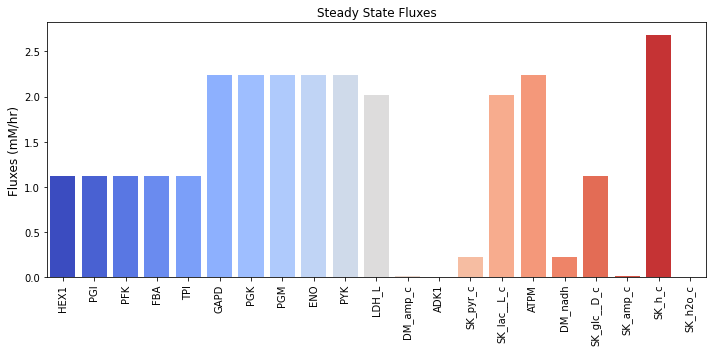

In [19]:
fig_10_3, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
# Define indicies for bar chart
indicies = np.arange(len(reaction_ids))+0.5
# Define colors to use
c = plt.cm.coolwarm(np.linspace(0, 1, len(reaction_ids)))
# Plot bar chart
ax.bar(indicies, ssfluxes.values(), width=0.8, color=c);
ax.set_xlim([0, len(reaction_ids)]);
# Set labels and adjust ticks
ax.set_xticks(indicies);
ax.set_xticklabels(reaction_ids, rotation="vertical");
ax.set_ylabel("Fluxes (mM/hr)", L_FONT);
ax.set_title("Steady State Fluxes", L_FONT);
fig_10_3.tight_layout()

**Figure 10.3:** Bar chart of the steady-state fluxes.

Note that there is a net production of a proton, leading to acidification of the surrounding medium, but no net production of water.  We can perform a numerical check make sure that we have a steady state flux vector by performing the multiplication $\textbf{Sv}_{\mathrm{stst}}$ that should yield zero.

**A numerical QC/QA**: Ensure $\textbf{Sv}_{\mathrm{stst}} = 0.$

In [20]:
pd.DataFrame(
    glycolysis.S.dot(np.array(list(ssfluxes.values()))),
    index=metabolite_ids, 
    columns=[r"$\textbf{Sv}_{\mathrm{stst}}$"]
    ).T

,glc__D_c,g6p_c,f6p_c,fdp_c,dhap_c,g3p_c,_13dpg_c,_3pg_c,_2pg_c,pep_c,pyr_c,lac__L_c,nad_c,nadh_c,amp_c,adp_c,atp_c,pi_c,h_c,h2o_c
$\textbf{Sv}_{\mathrm{stst}}$,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


### Computing the PERCs  
Glycolysis contains both reversible and effectively irreversible reactions. The approximate steady state values of the metabolites are given above. The mass action ratios can be computed from these steady state concentrations and are all smaller than the corresponding equilibrium constants (i.e., $\Gamma < K_{eq}$), and thus the reactions are proceeding in the forward direction. We can compute the forward rate constant for reaction i from 

$$\begin{equation} k_i = \frac{\text{flux through reaction}}{(\Pi_i\text{reactants}_i - \Pi_i\text{products}_i/K_{eq})} \tag{10.4} \end{equation}$$

In [21]:
percs = glycolysis.calculate_PERCs(update_reactions=True)

**Table 10.10:** Glycolytic enzymes, loads, transport rates, and their abbreviations. In addition, the glucose influx rate is set at 1.12 mM/hr and the AMP influx rate is set at 0.014 mM/hr based on data, see (Joshi 1988). For irreversible reactions, the numerical value for the equilibrium constants is $\infty$, which, for practical reasons, can be set to a finite value.

In [22]:
# Get concentration values for substitution into sympy expressions
value_dict = {sym.Symbol(str(met)): ic 
              for met, ic in glycolysis.initial_conditions.items()}
value_dict.update({sym.Symbol(str(met)): bc 
                   for met, bc in glycolysis.boundary_conditions.items()})

table_10_10 = []
# Get symbols and values for table and substitution
for p_key in ["Keq", "kf"]:
    symbol_list, value_list = [], []
    for p_str, value in glycolysis.parameters[p_key].items():
        symbol_list.append(r"$%s_{\text{%s}}$" % (p_key[0], p_str.split("_", 1)[-1]))
        value_list.append("{0:.3f}".format(value) if value != INF else r"$\infty$")
        value_dict.update({sym.Symbol(p_str): value})
    table_10_10.extend([symbol_list, value_list])

table_10_10.append(["{0:.6f}".format(float(ratio.subs(value_dict)))
                    for ratio in strip_time(glycolysis.get_mass_action_ratios()).values()])
table_10_10.append(["{0:.6f}".format(float(ratio.subs(value_dict)))
                    for ratio in strip_time(glycolysis.get_disequilibrium_ratios()).values()])
table_10_10 = pd.DataFrame(np.array(table_10_10).T, index=reaction_ids,
                           columns=[r"$K_{eq}$ Symbol", r"$K_{eq}$ Value", "PERC Symbol", 
                                    "PERC Value", r"$\Gamma$", r"$\Gamma/K_{eq}$"])
table_10_10

,$K_{eq}$ Symbol,$K_{eq}$ Value,PERC Symbol,PERC Value,$\Gamma$,$\Gamma/K_{eq}$
HEX1,$K_{\text{HEX1}}$,850.000,$k_{\text{HEX1}}$,0.700,0.008809,0.000010
PGI,$K_{\text{PGI}}$,0.410,$k_{\text{PGI}}$,3644.444,0.407407,0.993677
PFK,$K_{\text{PFK}}$,310.000,$k_{\text{PFK}}$,35.369,0.133649,0.000431
FBA,$K_{\text{FBA}}$,0.082,$k_{\text{FBA}}$,2834.568,0.079781,0.972937
TPI,$K_{\text{TPI}}$,0.057,$k_{\text{TPI}}$,34.356,0.045500,0.796249
GAPD,$K_{\text{GAPD}}$,0.018,$k_{\text{GAPD}}$,3376.749,0.006823,0.381183
PGK,$K_{\text{PGK}}$,1800.000,$k_{\text{PGK}}$,1273531.270,1755.073081,0.975041
PGM,$K_{\text{PGM}}$,0.147,$k_{\text{PGM}}$,4868.589,0.146184,0.994048
ENO,$K_{\text{ENO}}$,1.695,$k_{\text{ENO}}$,1763.741,1.504425,0.887608
PYK,$K_{\text{PYK}}$,363000.000,$k_{\text{PYK}}$,454.386,19.570304,0.000054


These estimates for the numerical values for the PERCs are shown in Table 10.10. These numerical values, along with the elementary form of the rate laws, complete the definition of the dynamic mass balances that can now be simulated. The steady state is specified in Table 10.9. Clearly, there are practical limitations for the computation of the PERCs from Eq. (10.4). If the reaction is close to equilibrium, then the denominator can be close to zero. If this is the case, the PERC is effectively indeterminable, but we know it is fast. The PERC can then be fixed to a large value and, in almost all cases, will correspond to dynamics that are too fast to be of interest. 

We note that these computations are automated in **MASSpy** using the `MassModel.calculate_PERCs` method but detailed here for illustrative purposes.

### Node maps  
These maps show all the flows of mass in and out of a node (a compound) in the network. Some of the key nodes in the glycolytic system are shown in Figure 10.4. The rate constants of the links into and out of a node can differ in their magnitude. They give us a measure of the spectrum of response times associated with a node. It is hard to excite some of the rapid dynamics associated with a node by perturbing a boundary flux; thus, such rapid motions are not often observed in dynamical simulations around a steady state. 

![Figure-10-4](../images/Ch10/Figure-10-4.png)

**Figure 10.4:** Node maps for key glycolytic intermediates. The node maps for $\textit{AMP}$, $\textit{NADH}$, $\textit{ATP}$, $\textit{P}_i$, $\textit{PYR}$, and $\textit{H}^+$ are shown. The flows in and out balance in the steady state.

## Simulating Mass Balances: Biochemistry  
In the first part,  we specified the glycolytic system, its contents, its steady state, and all numerical values needed to simulate its dynamic responses. Such simulations can be done for perturbations in the energy or redox loads, in environmental parameters like the external PYR and LAC concentrations, or in the influx of the two forcing functions, for glucose or AMP. Here, we will simulate the response to an increased rate of use of ATP.

### Validating the steady state 
As a QC/QA test, we start by simulating the glycolytic system without perturbing it to make sure that the initial conditions represent a steady state.

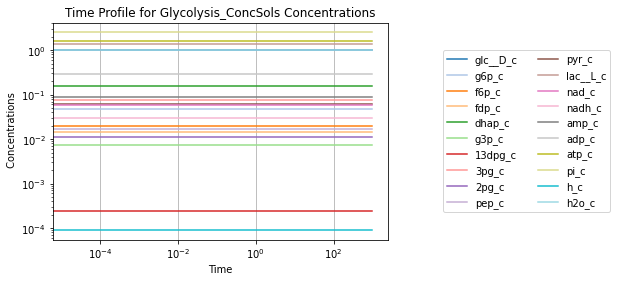

In [23]:
t0, tf = (0, 1e3)
sim_glycolysis = Simulation(glycolysis)
conc_sol_ss, flux_sol_ss = sim_glycolysis.simulate(
    glycolysis, time=(t0, tf))
conc_sol_ss.view_time_profile()

**Figure 10.5:** Simulating the glycolytic system from the steady state with no perturbation.

### Response to an increased $k_{ATPM}$ at a constant glucose input rate  
We focus here on a perturbation in the ATP load, where we increase the $k_{ATPM}$ parameter by 50% at $t = 0$ and simulate the dynamic response to a new steady state. In Chapter 8 we studied this same perturbation in an idealized toy system. This perturbation reflects a change in the rate of usage of ATP.

In [24]:
conc_sol, flux_sol = sim_glycolysis.simulate(
    glycolysis, time=(t0, tf),
    perturbations={"kf_ATPM": "kf_ATPM * 1.5"},
    interpolate=True)

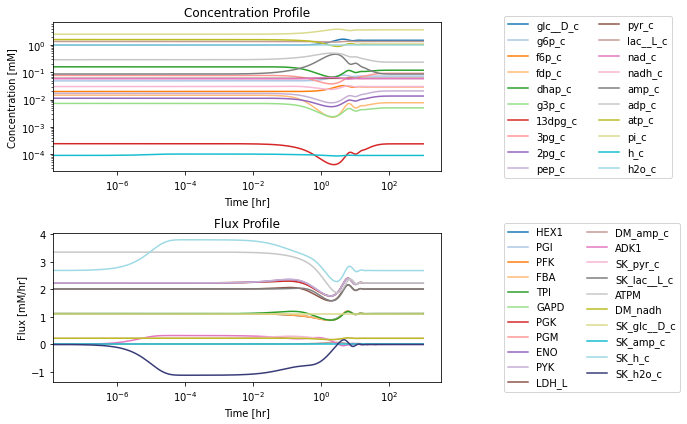

In [25]:
fig_10_6, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6));
(ax1, ax2) = axes.flatten()

plot_time_profile(
    conc_sol, ax=ax1, legend="right outside", 
    plot_function="loglog", 
    xlabel="Time [hr]", ylabel="Concentration [mM]", 
    title=("Concentration Profile", L_FONT));

plot_time_profile(
    flux_sol, ax=ax2, legend="right outside", 
    plot_function="semilogx", 
    xlabel="Time [hr]", ylabel="Flux [mM/hr]", 
    title=("Flux Profile", L_FONT));
fig_10_6.tight_layout()

**Figure 10.6:** Simulating the glycolytic system from the steady state with 50% increase in the rate of ATP utilization at t = 0.

#### A multi-scale response

To get the full response, the time scale is shown on a log scale. The full time response shows that there are roughly three time scales of interest. These are consistent with distribution of numerical values of PERCs in Table 10.11. We have roughly three time scales of interest: <0.1 hr, 0.1 to 10 hr, and 10 to 100 hr.  The initial perturbation imbalances a few nodes immediately, that then activates fluxes with fast time scales that then serially over time lead to dynamic responses on subsequent time scales.  

#### Relative deviations from the initial state  
The solution shows that the concentrations are spread over many orders of magnitude. We can judge the magnitude of the perturbation from the steady state by normalizing the concentrations to their initial conditions.

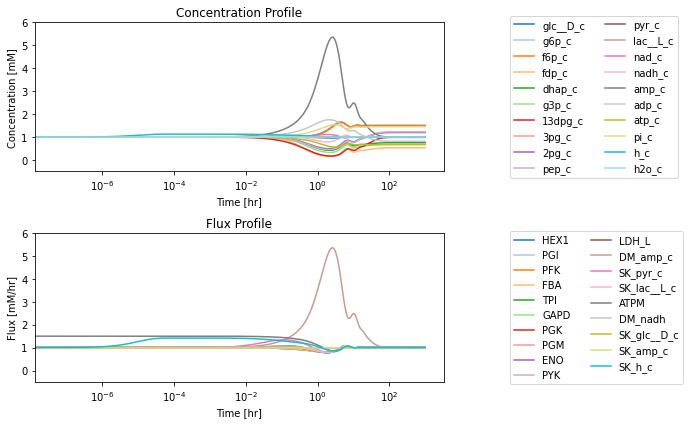

In [26]:
fig_10_7, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6));
(ax1, ax2) = axes.flatten()
conc_sol.interpolate=False
conc_deviation = {met.id: conc_sol[met.id]/ic 
                  for met, ic in glycolysis.initial_conditions.items()}
conc_deviation = MassSolution(
    "Deviation", solution_type="Conc",
    data_dict=conc_deviation,
    time=conc_sol.t, interpolate=False)

flux_sol.interpolate = False
flux_deviation = {rxn.id: flux_sol[rxn.id]/ssflux 
                  for rxn, ssflux in glycolysis.steady_state_fluxes.items()
                  if ssflux != 0} # To avoid dividing by 0 for equilibrium fluxes.

flux_deviation = MassSolution(
    "Deviation", solution_type="Flux",
    data_dict=flux_deviation, 
    time=flux_sol.t, interpolate=False)

plot_time_profile(
    conc_deviation, ax=ax1, legend="right outside", 
    plot_function="semilogx", ylim=(-.5, 6),
    xlabel="Time [hr]", ylabel="Concentration [mM]", 
    title=("Concentration Profile", L_FONT));

plot_time_profile(
    flux_deviation, ax=ax2, legend="right outside", 
    plot_function="semilogx", ylim=(-.5, 6),
    xlabel="Time [hr]", ylabel="Flux [mM/hr]", 
    title=("Flux Profile", L_FONT));
fig_10_7.tight_layout()

**Figure 10.7:** (a) Deviation from the steady state of the concentrations as a fraction of the steady state. (b) Deviation from the steady state of the fluxes as a fraction of the steady state.

* The concentration of AMP shows the most significant perturbation from its initial steady state.  The phosphate and glucose concentrations change the most in the new steady state. Similarly, we can examine how much the fluxes deviate from their inital steady state values.

* We see that the flux map is immediately imbalanced at short times with the proton efflux $(v_{SK_{h}})$ and the pyruvate efflux $(v_{SK_{pyr}})$ taking large values relative to the steady state.  The nodes that they are connected to will thus imbalance, and the perturbation of the corresponding concentration will be determined by the change in the flux relative to the initial concentration.  

Since the forced unbalancing of the two inputs (glucose and AMP) are the same, the eventual flux map will balance out the same way as the pre-perturbation steady state. The eventual value of the ATP demand flux will end up at 2/3rds of its initial value since it was perturbed by 50% at $t=0.$

**Table 10.11:** Numerical values for the concentrations (mM) and fluxes (mM/hr) at the beginning and end of the dynamic simulation. The concentration of water is arbitrarily set at 1.0. At $t=0$ the $v_{ATPM}$ flux changes from 2.24 to 3.36, unbalancing the flux map. The flux map returns to its original state as time goes to infinity (here $t=1000$). Note that unlike the fluxes, the concentrations reach a different steady state.

In [27]:
met_ids = metabolite_ids.copy()
init_concs = [round(ic[0], 3) for ic in conc_sol.values()]
final_concs = [round(bc[-1], 3) for bc in conc_sol.values()]
column_labels = ["Metabolite", "Conc. at t=0 [mM]", "Conc. at t=1000 [mM]"]

rxn_ids = reaction_ids.copy()
init_fluxes = [round(ic[0], 3) for ic in flux_sol.values()]
final_fluxes = [round(bc[-1], 3) for bc in flux_sol.values()]
column_labels += ["Reactions", "Flux at t=0 [mM/hr]", "Flux at t=1000 [mM/hr]"]

# Extend metabolite columns to match length of reaction columns for table
pad = [""]*(len(reaction_ids) - len(metabolite_ids))
# Make table
table_10_11 = np.array([metabolite_ids + pad, init_concs + pad, final_concs + pad, 
                        reaction_ids, init_fluxes, final_fluxes])
table_10_11 = pd.DataFrame(table_10_11.T, 
                           index=[i for i in range(1, len(reaction_ids) + 1)],
                           columns=column_labels)
def highlight_table(x):
    # ATPM is the 16th reaction according to Table 10.2
    return ['color: red' if x.name == 16 else '' for v in x]

table_10_11 = table_10_11.style.apply(highlight_table, subset=column_labels[3:], axis=1)
table_10_11

,Metabolite,Conc. at t=0 [mM],Conc. at t=1000 [mM],Reactions,Flux at t=0 [mM/hr],Flux at t=1000 [mM/hr]
1,glc__D_c,1.0,1.5,HEX1,1.12,1.12
2,g6p_c,0.049,0.073,PGI,1.12,1.12
3,f6p_c,0.02,0.03,PFK,1.12,1.12
4,fdp_c,0.015,0.008,FBA,1.12,1.12
5,dhap_c,0.16,0.12,TPI,1.12,1.12
6,g3p_c,0.007,0.005,GAPD,2.24,2.24
7,_13dpg_c,0.0,0.0,PGK,2.24,2.24
8,_3pg_c,0.077,0.093,PGM,2.24,2.24
9,_2pg_c,0.011,0.014,ENO,2.24,2.24
10,pep_c,0.017,0.021,PYK,2.24,2.24


**A numerical QC/QA:** We can make sure that we have the steady state flux map by computing the flux balances as $\textbf{Sv}$ and determine if they are zero.

In [28]:
final_fluxes = [round(bc[-1], 3) for bc in flux_sol.values()]
Sv_qcqa = np.array([[round(value, 5) for value in glycolysis.S.dot(final_fluxes)]])
Sv_qcqa = pd.DataFrame(Sv_qcqa, index=["Sv after perturbation"], columns=metabolite_ids, dtype=np.int64)
Sv_qcqa

,glc__D_c,g6p_c,f6p_c,fdp_c,dhap_c,g3p_c,_13dpg_c,_3pg_c,_2pg_c,pep_c,pyr_c,lac__L_c,nad_c,nadh_c,amp_c,adp_c,atp_c,pi_c,h_c,h2o_c
Sv after perturbation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Node balances
Although the response is not high dimensional, it is difficult to conceptualize. We begin to untangle the dynamic state by examining the node balances. The sudden increase in the usage rate of the ATP demand reaction: $\text{ATP} + \text{H}_2\text{O} \rightarrow \text{ADP} + \text{P}_i + \text{H}$, there is a sudden increase in all the products of the reactions that in turn cause perturbations through the network. We now look at the node balances for each of these products.

#### The proton node
The proton node is imbalanced at time zero with the increased flux of the ATP demand reaction. The proton node has a connectivity of 8; five production reactions and three utilization reactions.  We can look at the node balance at the beginning of the simulation, i.e. the imbalanced state, and compare it with the balanced state at the end of the simulation.

The fluxes in and out of the node can be graphed, and so can the proton concentration (the 'inventory' in the node).

In [29]:
h_c = glycolysis.metabolites.h_c
fluxes_in = []
fluxes_out = []
for reaction in glycolysis.reactions:
    if h_c in reaction.reactants:
        fluxes_out.append(reaction.id)
    if h_c in reaction.products:
        fluxes_in.append(reaction.id)

print(fluxes_in, "Produce\n")
print(fluxes_out, "Consume\n")

['HEX1', 'PFK', 'GAPD', 'ATPM', 'DM_nadh'] Produce

['PYK', 'LDH_L', 'SK_h_c'] Consume



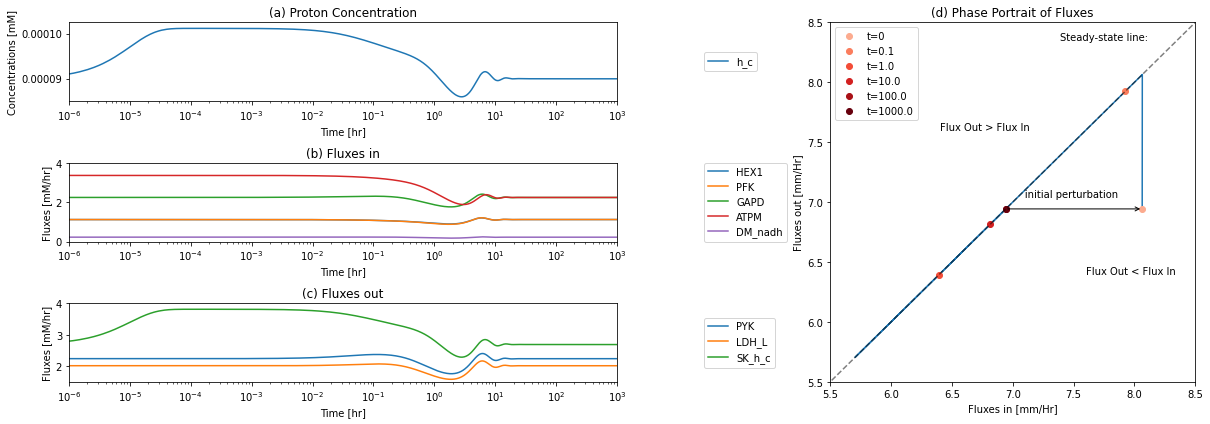

In [30]:
fig_10_8 = plt.figure(figsize=(17, 6))
gs = fig_10_8.add_gridspec(nrows=3, ncols=2, width_ratios=[1.5, 1])

ax1 = fig_10_8.add_subplot(gs[0, 0])
ax2 = fig_10_8.add_subplot(gs[1, 0])
ax3 = fig_10_8.add_subplot(gs[2, 0])
ax4 = fig_10_8.add_subplot(gs[:, 1])

plot_time_profile(
    conc_sol, observable="h_c", ax=ax1, 
    legend="right outside", plot_function="semilogx",
    xlim=(1e-6, tf), ylim=(8.5e-5, 1e-4*1.025),
    xlabel="Time [hr]", ylabel="Concentrations [mM]",
    title=("(a) Proton Concentration", L_FONT));

fluxes_in = ["HEX1", "PFK","GAPD", "ATPM", "DM_nadh"]
plot_time_profile(
    flux_sol, observable=fluxes_in, ax=ax2,
    legend="right outside", plot_function="semilogx",
    xlim=(1e-6, tf),  ylim=(0, 4),
    xlabel="Time [hr]", ylabel="Fluxes [mM/hr]",
    title=("(b) Fluxes in", L_FONT));

fluxes_out = ["PYK", "LDH_L", "SK_h_c"]
plot_time_profile(
    flux_sol, observable=fluxes_out, ax=ax3, 
    legend="right outside", plot_function="semilogx",
    xlim=(1e-6, tf),  ylim=(1.5, 4),
    xlabel="Time [hr]", ylabel="Fluxes [mM/hr]",
    title=("(c) Fluxes out", L_FONT));

for flux_id, variables in zip(["Net_Flux_In", "Net_Flux_Out"],
                              [fluxes_in, fluxes_out]):
    flux_sol.make_aggregate_solution(
        flux_id, equation=" + ".join(variables), variables=variables)
    
time_points = [t0, 1e-1, 1e0, 1e1, 1e2, tf]
time_point_colors = [
    mpl.colors.to_hex(c)
    for c in mpl.cm.Reds(np.linspace(0.3, 1, len(time_points)))]

plot_phase_portrait(
    flux_sol, x="Net_Flux_In", y="Net_Flux_Out", ax=ax4,
    xlim=(5.5, 8.5), ylim=(5.5, 8.5),
    xlabel="Fluxes in [mm/Hr]", ylabel="Fluxes out [mm/Hr]",
    title=("(d) Phase Portrait of Fluxes", L_FONT),
    annotate_time_points=time_points,
    annotate_time_points_color=time_point_colors,
    annotate_time_points_legend="best");

ax4.plot([5.0, 9.0], [5.0, 9.0], ls="--", color="black", alpha=0.5)
xy = (flux_sol["Net_Flux_In"][0], flux_sol["Net_Flux_Out"][0])
xytext = (sum([flux_sol_ss[rxn][-1] for rxn in fluxes_in]), 
          sum([flux_sol_ss[rxn][-1] for rxn in fluxes_out]))
ax4.annotate("Steady-state line:", xy=(0.63, 0.95), xycoords="axes fraction");
ax4.annotate("Flux Out < Flux In", xy=(0.7, 0.3), xycoords="axes fraction");
ax4.annotate("Flux Out > Flux In", xy=(0.3, 0.7), xycoords="axes fraction");
ax4.annotate("      initial perturbation\n", xy=xy, xytext=xytext, textcoords="data");
ax4.annotate("", xy=xy, xytext=xytext, textcoords="data",
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3"));
fig_10_8.tight_layout()

**Figure 10.8:**	The time profiles of the (a) proton concentration, (b) the fluxes that make protons, (c) the fluxes that use protons and (d) the phase portrait of the net flux in and net flux out (darker red colors indicate slower time scales).

The ATP load reaction initially imbalances the node, and the proton efflux reacts to the proton fluctuation. We thus look at a phase plane representing these two fluxes.

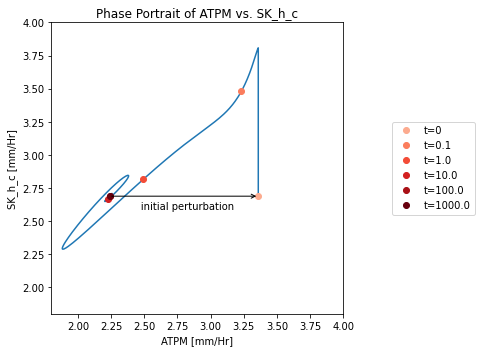

In [31]:
fig_10_9, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))

plot_phase_portrait(
    flux_sol, x="ATPM", y="SK_h_c", ax=ax,
    xlabel="ATPM [mm/Hr]", ylabel="SK_h_c [mm/Hr]", xlim=(1.8, 4), ylim=(1.8, 4),
    title=("Phase Portrait of ATPM vs. SK_h_c", L_FONT),
    annotate_time_points=time_points,
    annotate_time_points_color=time_point_colors,
    annotate_time_points_legend="right outside")

xy = (flux_sol["ATPM"][0], flux_sol["SK_h_c"][0])
xytext = (flux_sol_ss["ATPM"][-1], flux_sol_ss["SK_h_c"][-1])
ax.annotate("              initial perturbation", xy=xy, xytext=tuple(i-.1 for i in xytext), textcoords="data");
ax.annotate("", xy=xy, xytext=xytext, textcoords="data",
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3"));
fig_10_9.tight_layout()

**Figure 10.9:** A phase portrait of the instantly imbalanced ATP demand flux and the proton exchange rate.

The ATP load is instantaneously moved to the $t_0$ point (i.e. changed from 2.24 to 3.36mM/hr).  The very rapidly responsive proton efflux immediately increases to pump out the proton and then the phase portrait moves approximately along an affine 45 degree line (offset by 0.3 mM/hr), as the proton efflux adjusts to the ATP load reaction. The initial rapid response of the proton efflux is likely to be an unrealistic response, as there is substantial intracellular buffer for protons.

#### The ATP node
The ATP and the opposite ADP node has a connectivity of 6; three producing reactions and three utilization reactions.  The sudden imbalance between ATP use and ATP production initially drops the ATP concentration.  The flux through the ATP utilizing kinases (HEX1 and PFK) in upper glycolysis thus goes down, with a mirrored reaction of the kinases in lower glycolysis (PGK and PYK). This dynamic interplay leads to ultimate steady state where ATP is at a lower concentration and so interestingly is ADP. The reason is that ADK1 forms AMP initially when ADP builds up and this leads to loss of AMP from the system. 

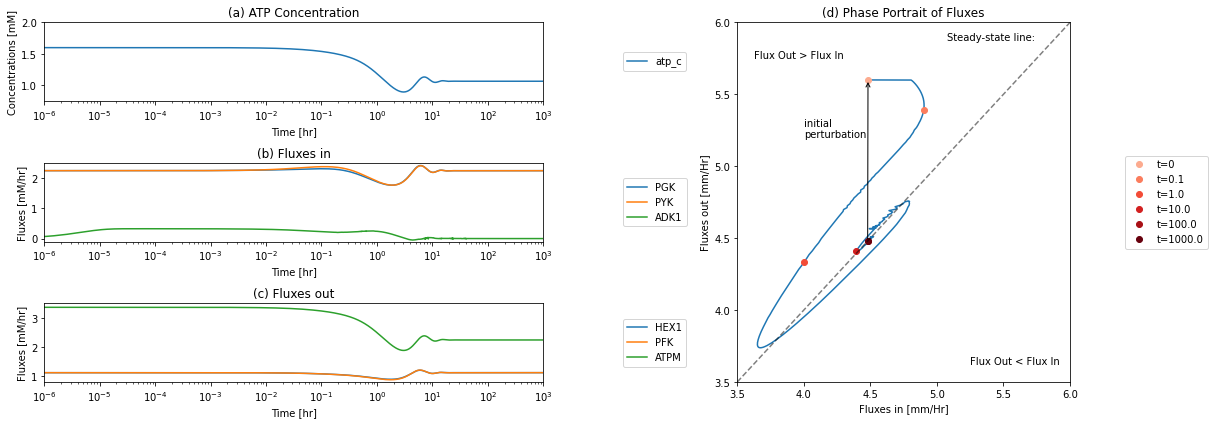

In [32]:
fig_10_10 = plt.figure(figsize=(17, 6))
gs = fig_10_10.add_gridspec(nrows=3, ncols=2, width_ratios=[1.5, 1])

ax1 = fig_10_10.add_subplot(gs[0, 0])
ax2 = fig_10_10.add_subplot(gs[1, 0])
ax3 = fig_10_10.add_subplot(gs[2, 0])
ax4 = fig_10_10.add_subplot(gs[:, 1])

plot_time_profile(
    conc_sol, observable="atp_c", ax=ax1, 
    legend="right outside", plot_function="semilogx",
    xlim=(1e-6, tf), ylim=(.75, 2),
    xlabel="Time [hr]", ylabel="Concentrations [mM]",
    title=("(a) ATP Concentration", L_FONT));

fluxes_in = ["PGK", "PYK","ADK1"]
plot_time_profile(
    flux_sol, observable=fluxes_in, ax=ax2,
    legend="right outside", plot_function="semilogx",
    xlim=(1e-6, tf), ylim=(-0.1, 2.5),
    xlabel="Time [hr]", ylabel="Fluxes [mM/hr]",
    title=("(b) Fluxes in", L_FONT));

fluxes_out = ["HEX1", "PFK", "ATPM"]
plot_time_profile(
    flux_sol, observable=fluxes_out, ax=ax3, 
    legend="right outside", plot_function="semilogx",
    xlim=(1e-6, tf), ylim=(.8, 3.5),
    xlabel="Time [hr]", ylabel="Fluxes [mM/hr]",
    title=("(c) Fluxes out", L_FONT));

for flux_id, variables in zip(["Net_Flux_In", "Net_Flux_Out"],
                              [fluxes_in, fluxes_out]):
    flux_sol.make_aggregate_solution(
        flux_id, equation=" + ".join(variables), variables=variables)
    
time_points = [t0, 1e-1, 1e0, 1e1, 1e2, tf]
time_point_colors = [
    mpl.colors.to_hex(c)
    for c in mpl.cm.Reds(np.linspace(0.3, 1, len(time_points)))]

plot_phase_portrait(
    flux_sol, x="Net_Flux_In", y="Net_Flux_Out", ax=ax4,
    xlim=(3.5, 6.0), ylim=(3.5, 6.0),
    xlabel="Fluxes in [mm/Hr]", ylabel="Fluxes out [mm/Hr]",
    title=("(d) Phase Portrait of Fluxes", L_FONT),
    annotate_time_points=time_points,
    annotate_time_points_color=time_point_colors,
    annotate_time_points_legend="right outside");


ax4.plot((3.5, 6.0), (3.5, 6.0), ls="--", color="black", alpha=0.5)
xy = (flux_sol["Net_Flux_In"][0], flux_sol["Net_Flux_Out"][0])
xytext = (sum([flux_sol_ss[rxn][-1] for rxn in fluxes_in]), 
          sum([flux_sol_ss[rxn][-1] for rxn in fluxes_out]))
ax4.annotate("Steady-state line:", xy=(0.63, 0.95), xycoords="axes fraction");
ax4.annotate("Flux Out < Flux In", xy=(0.7, 0.05), xycoords="axes fraction");
ax4.annotate("Flux Out > Flux In", xy=(0.05, 0.9), xycoords="axes fraction");
ax4.annotate("initial\nperturbation", xy=xy, xytext=(4, 5.2), textcoords="data");
ax4.annotate("", xy=xy, xytext=xytext, textcoords="data",
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3"));
fig_10_10.tight_layout()

#### The AMP node
The AMP node has a connectivity of 3. The influx is fixed at 0.014 mM/hr, the exit rate of AMP is proportional to its concentration, and ADK1 establishes a quasi-equilibrium state between ATP, ADP and AMP.  Thus by plotting a phase plane of $v_{ATPM}$ and $v_{DM_{AMP}}$ we can relate the three fluxes. After the imbalancing of the ATP demand reaction AMP builds up that leads to the efflux being higher than the input rate, Figure 10.11a.  This can also be seen in a phase portrait of the ADK1 and AMP exit flux, Figure 10.11b.   

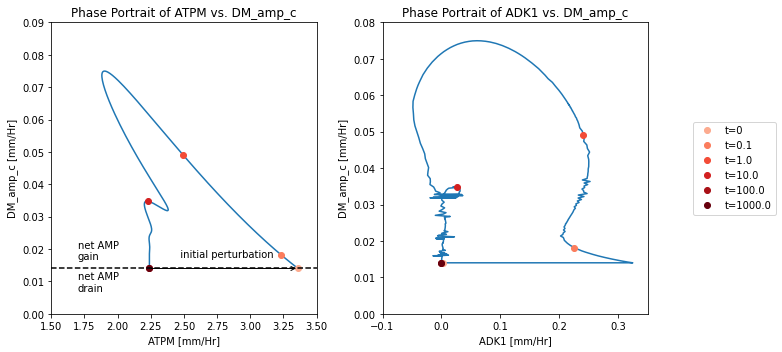

In [33]:
fig_10_11, axes = plt.subplots(nrows=1, ncols=2, figsize=(11, 5))
(ax1, ax2) = axes.flatten()

plot_phase_portrait(
    flux_sol, x="ATPM", y="DM_amp_c", ax=ax1,
    xlim=(1.5, 3.5), ylim=(0, 0.09),
    xlabel="ATPM [mm/Hr]", ylabel="DM_amp_c [mm/Hr]",
    title=("Phase Portrait of ATPM vs. DM_amp_c", L_FONT),
    annotate_time_points=time_points,
    annotate_time_points_color=time_point_colors);

# Annotate plot
ax1.plot((1.5, 3.5), [flux_sol_ss["DM_amp_c"][-1]]*2, 
         ls="--", color="black");
ax1.annotate("net AMP\ngain", xy=(1.7, flux_sol_ss["DM_amp_c"][-1]*1.2));
ax1.annotate("net AMP\ndrain", xy=(1.7, flux_sol_ss["DM_amp_c"][-1]*.5));

xy = (flux_sol["ATPM"][0], flux_sol["DM_amp_c"][0])
xytext = (flux_sol_ss["ATPM"][-1], flux_sol_ss["DM_amp_c"][-1])

ax1.annotate("          initial perturbation\n",
             xy=xy, xytext=tuple(i for i in xytext),
             textcoords="data");
ax1.annotate("", xy=xy, xytext=xytext, textcoords="data",
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3"));

plot_phase_portrait(
    flux_sol, x="ADK1", y="DM_amp_c", ax=ax2,
    xlim=(-0.1, 0.35), ylim=(0, 0.08),
    xlabel="ADK1 [mm/Hr]", ylabel="DM_amp_c [mm/Hr]",
    title=("Phase Portrait of ADK1 vs. DM_amp_c", L_FONT),
    annotate_time_points=time_points,
    annotate_time_points_color=time_point_colors,
    annotate_time_points_legend="right outside");
fig_10_11.tight_layout()

**Figure 10.11:**	Illustrating the AMP node response through flux phase portraits. (a) Phase portrait of $v_{ATPM}$ vs. $v_{DM_{AMP}}$. (b) Phase portrait of $v_{ADK1}$ vs. $v_{DM_{AMP}}$*

#### The inorganic phosphate node
The $\text{P}_i$ node has a connectivity of 2; one input and one output. The two fluxes can be plotted as a function of time, or on a phase portrait. The imbalancing of the phosphate pool is initially met by a slight increase in phosphate incorporation by GAPD. That is short lived as the flux in upper glycolysis drops.  Thus this node takes a long time to get into balance leading to substantial increase in free inorganic phosphate concentration.  Since the total phosphate is a constant in the system, this leads to systemic constraints on the total concentration of all phosphorylated compounds.

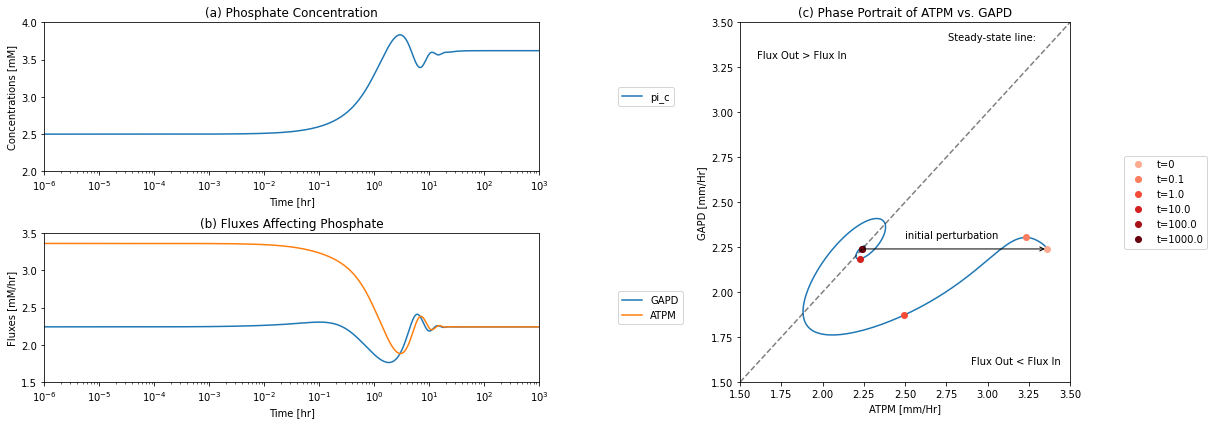

In [34]:
fig_10_12 = plt.figure(figsize=(17, 6))
gs = fig_10_12.add_gridspec(nrows=2, ncols=2, width_ratios=[1.5, 1])

ax1 = fig_10_12.add_subplot(gs[0, 0])
ax2 = fig_10_12.add_subplot(gs[1, 0])
ax3 = fig_10_12.add_subplot(gs[:, 1])

plot_time_profile(
    conc_sol, observable="pi_c", ax=ax1, 
    legend="right outside", plot_function="semilogx",
    xlim=(1e-6, tf), ylim=(2, 4),
    xlabel="Time [hr]", ylabel="Concentrations [mM]",
    title=("(a) Phosphate Concentration", L_FONT));

plot_time_profile(
    flux_sol, observable=["GAPD", "ATPM"], ax=ax2,
    legend="right outside", plot_function="semilogx",
    xlim=(1e-6, tf), ylim=(1.5, 3.5), 
    xlabel="Time [hr]", ylabel="Fluxes [mM/hr]",
    title=("(b) Fluxes Affecting Phosphate", L_FONT));

plot_phase_portrait(
    flux_sol, x="ATPM", y="GAPD", ax=ax3,
    xlim=(1.5, 3.5), ylim=(1.5, 3.5),
    xlabel="ATPM [mm/Hr]", ylabel="GAPD [mm/Hr]",
    title=("(c) Phase Portrait of ATPM vs. GAPD", L_FONT),
    annotate_time_points=time_points,
    annotate_time_points_color=time_point_colors,
    annotate_time_points_legend="right outside");

ax3.plot((1.5, 3.5), (1.5, 3.5), ls="--", color="black", alpha=0.5)
xy = (flux_sol["ATPM"][0], flux_sol["GAPD"][0])
xytext = (flux_sol_ss["ATPM"][-1], flux_sol_ss["GAPD"][-1])
ax3.annotate("Steady-state line:", xy=(0.63, 0.95),
             xycoords="axes fraction");
ax3.annotate("Flux Out < Flux In", xy=(0.7, 0.05),
             xycoords="axes fraction");
ax3.annotate("Flux Out > Flux In", xy=(0.05, 0.9),
             xycoords="axes fraction");
ax3.annotate("initial perturbation", xy=xy, xytext=(2.5, 2.3),
             textcoords="data");
ax3.annotate("", xy=xy, xytext=xytext, textcoords="data",
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3"));
fig_10_12.tight_layout()

**Figure 10.12:** The time profiles of the (a) inorganic phosphate concentration, (b) the two fluxes that make and consume inorganic phosphate, and (c) the phase portrait of the net flux in and net flux out (darker red colors indicate slower time scales).

#### Key Fluxes and all pairwise phase portraits

Figure 10.13 and Figure 10.14 are set up to allow the reader to examine all pairwise phase portraits  After browsing through many of them, you will find that they resemble each other, showing that the variables move in a highly coordinated manner.  We can study the relationship between many variables at once using multi-variate statistics.  

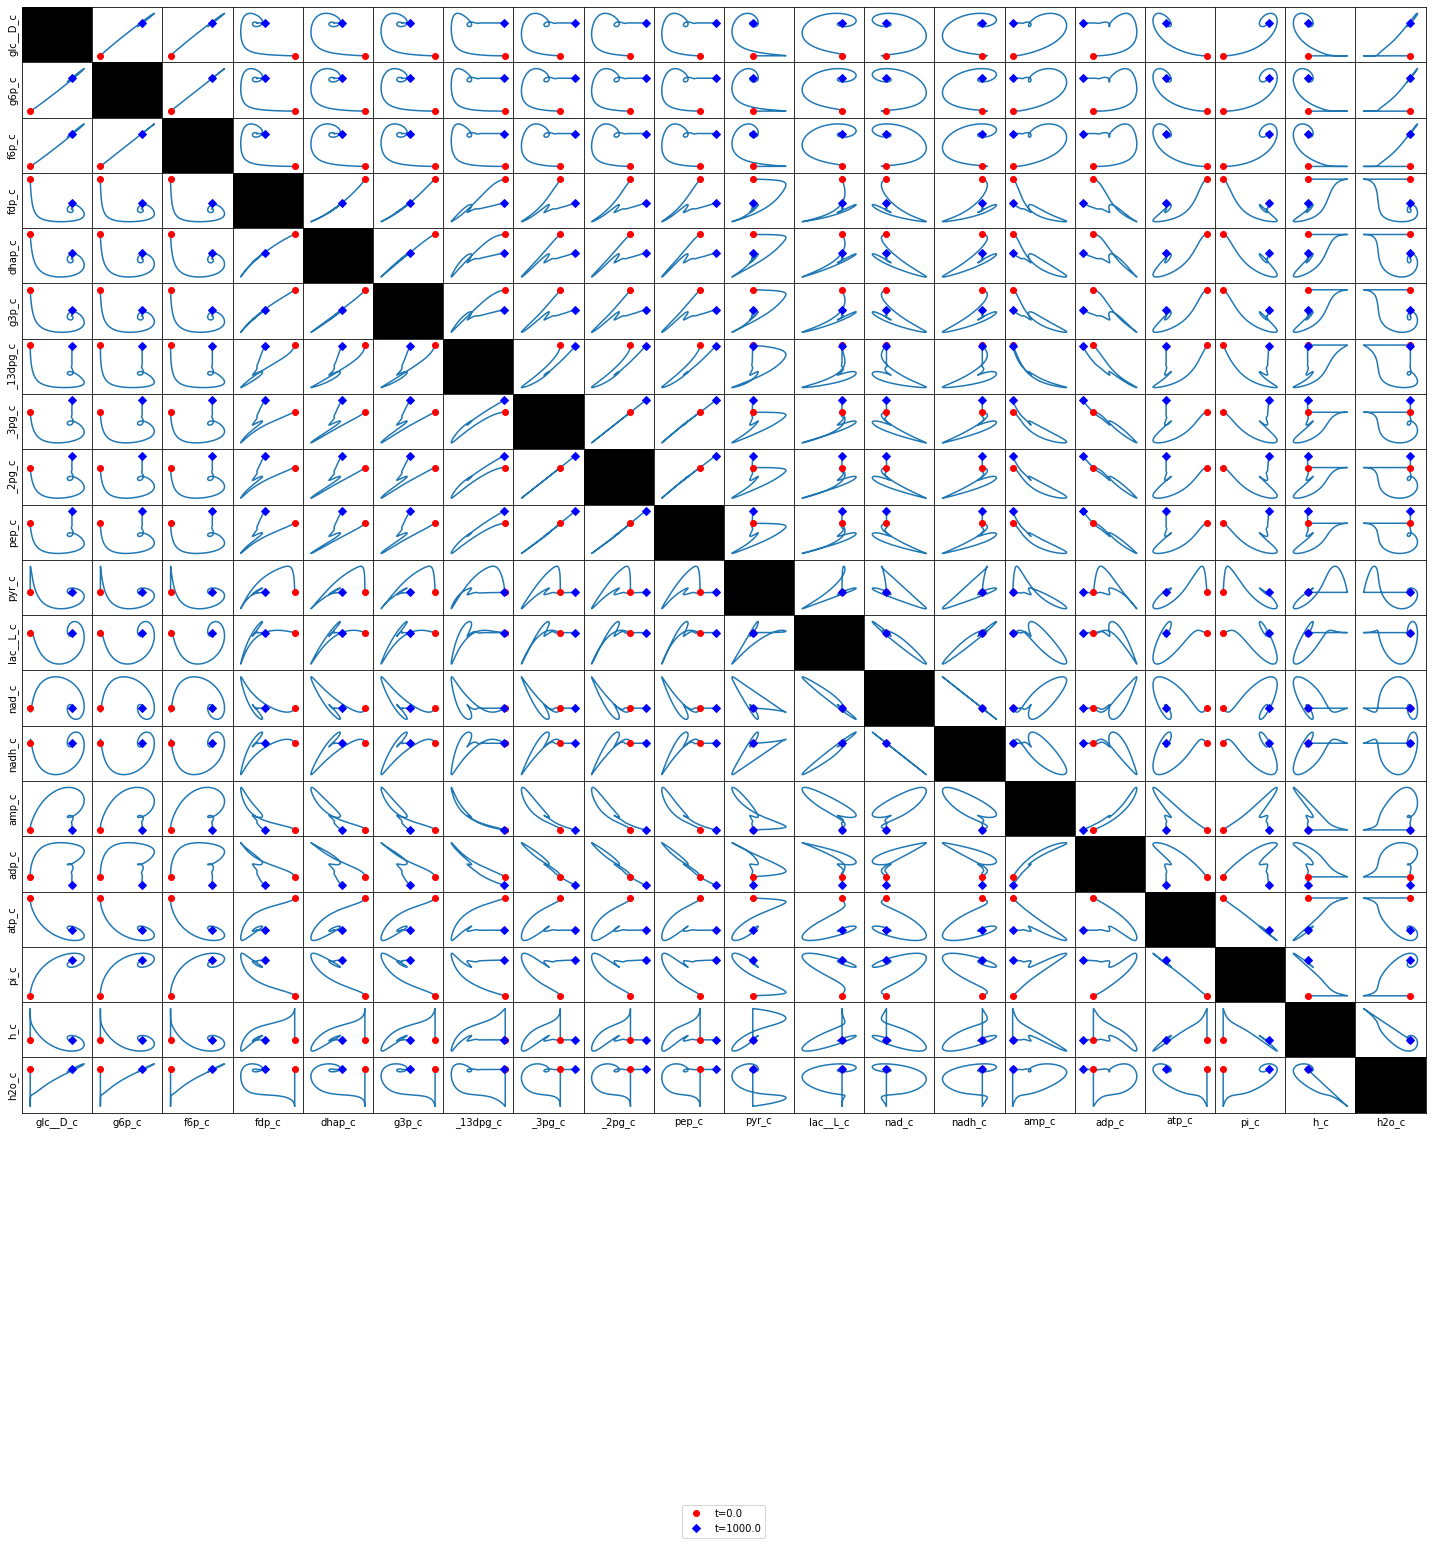

In [35]:
fig_10_13, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 22))
plot_tiled_phase_portraits(
    conc_sol, ax=ax, annotate_time_points_legend="lower outside");
fig_10_13.tight_layout()

**Figure 10.13:** Phase portraits of all the glycolytic species.

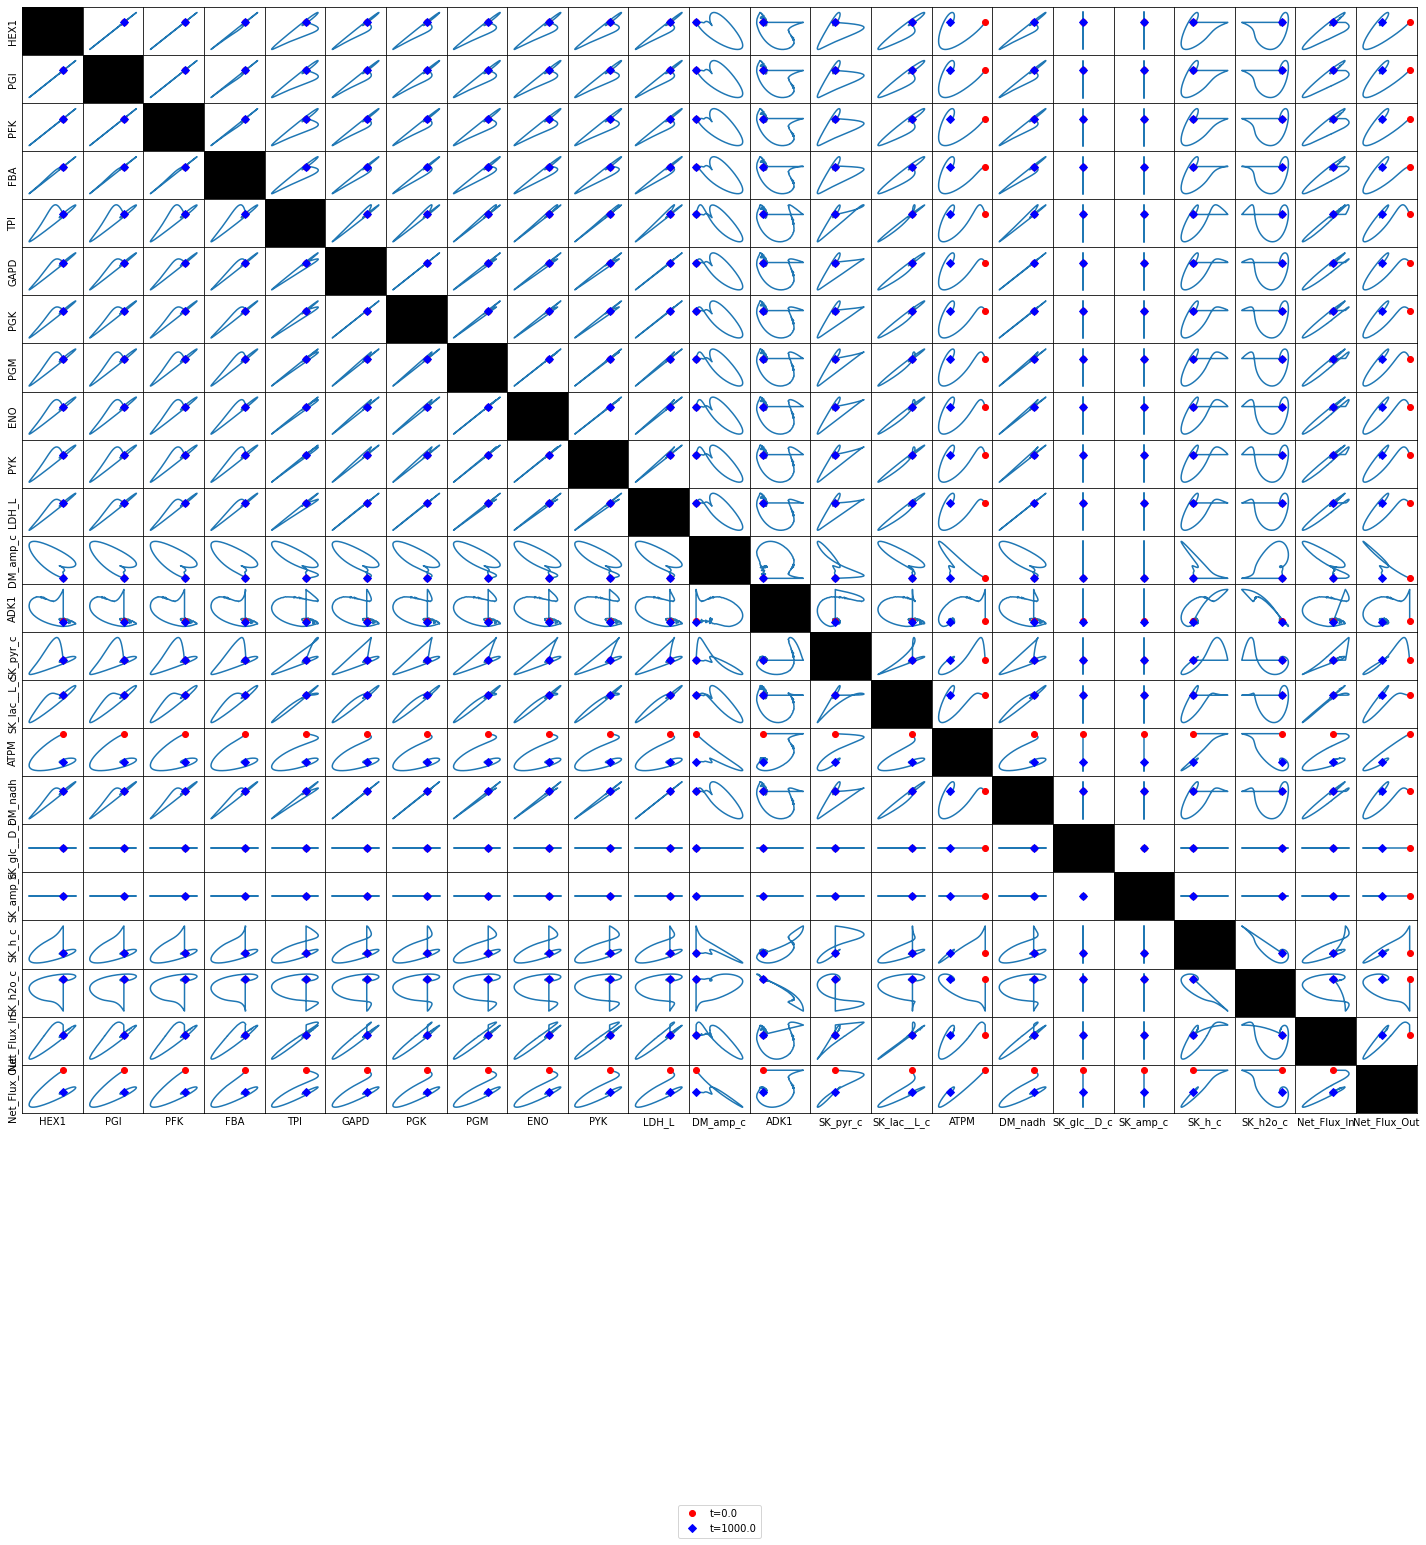

In [36]:
fig_10_14, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 22))
plot_tiled_phase_portraits(
    flux_sol, ax=ax, annotate_time_points_legend="lower outside");
fig_10_14.tight_layout()

**Figure 10.14:** Phase portraits of all the glycolytic fluxes.

You can quickly figure out the relationships between the kinases as a group and the two dehydrogenases. You can also figure out why pyruvate efflux has a sudden increase by looking at the pyruvate node.

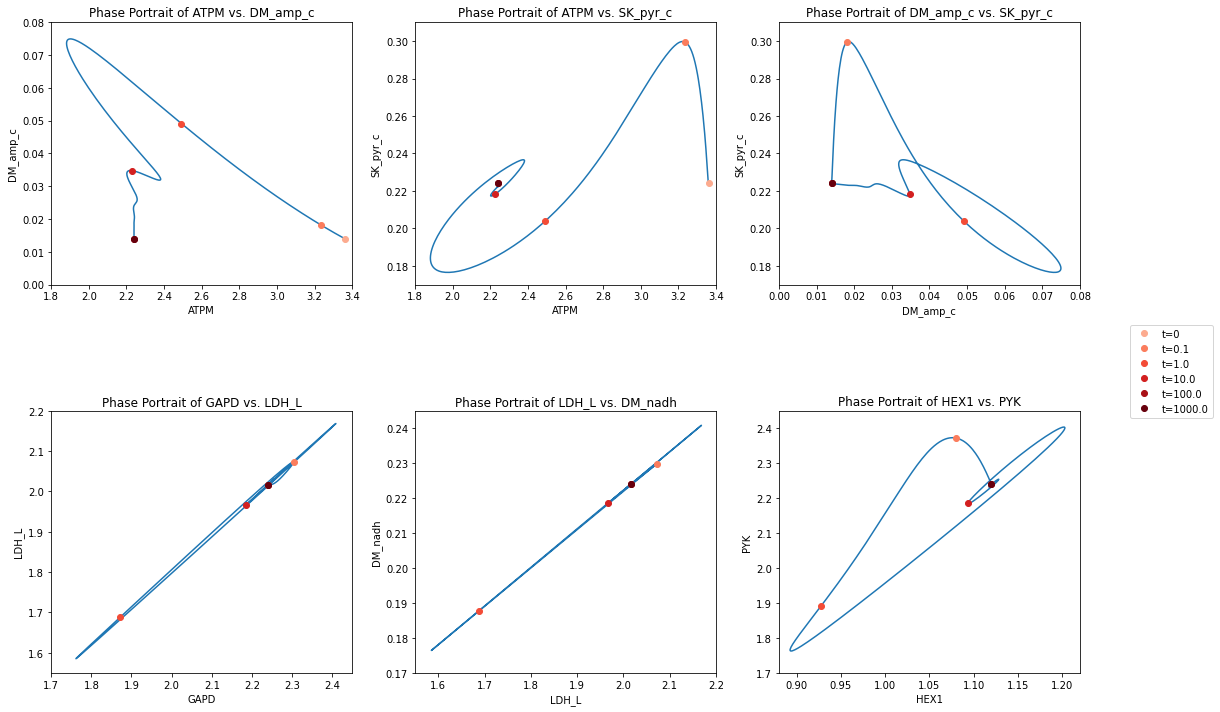

In [37]:
fig_10_15, axes = plt.subplots(nrows=2, ncols=3, figsize=(17, 10))
axes = axes.flatten()

time_points = [t0, 1e-1, 1e0, 1e1, 1e2, tf]
time_point_colors = [
    mpl.colors.to_hex(c)
    for c in mpl.cm.Reds(np.linspace(0.3, 1, len(time_points)))]

pairings = [
    ("ATPM", "DM_amp_c"), ("ATPM", "SK_pyr_c"), ("DM_amp_c", "SK_pyr_c"), 
    ("GAPD", "LDH_L"), ("LDH_L", "DM_nadh"), ("HEX1", "PYK")]
xlims = [
    (1.80, 3.40), (1.80, 3.40), (0.00, 0.08),
    (1.70, 2.45), (1.55, 2.200), (0.88, 1.22)]
ylims = [
    (0.00, 0.08), (0.17, 0.31), (0.17, 0.31),
    (1.55, 2.20), (0.17, 0.245), (1.70, 2.45)]

for i, ax in enumerate(axes):
    x_i, y_i = pairings[i]
    # Create a legend for the points of interest
    if i == len(axes) - 1:
        legend="upper right outside"
    else:
        legend = None
    plot_phase_portrait(
        flux_sol, x=x_i, y=y_i, ax=ax, 
        xlabel=x_i, ylabel=y_i, 
        xlim=xlims[i], ylim=ylims[i],
        title=("Phase Portrait of {0} vs. {1}".format(x_i, y_i), L_FONT),
        annotate_time_points=time_points,
        annotate_time_points_color=time_point_colors,
        annotate_time_points_legend=legend)
fig_10_15.tight_layout()

**Figure 10.15:** The dynamic response of key fluxes. Detailed pair-wise phase portraits: a): $v_{ATPM}$ vs. $v_{DM_{AMP}}$. b): $v_{ATPM}$ vs. $v_{SK_{pyr}}$. c): $v_{DM_{AMP}}$ vs. $v_{SK_{pyr}}$. d): $v_{GAPD}$ vs. $v_{LDH_{L}}$. e): $v_{LDH_{L}}$ vs. $v_{DM_{NADH}}$. f): $v_{HEX1}$ vs. $v_{PYK}$. The fluxes are in units of mM/hr. The perturbation is reflected in the instantaneous move of the flux state from the initial steady state to an unsteady state, as indicated by the arrow placing the initial point at $t = 0^+.$ The system then returns to its steady state at $t \rightarrow \infty$*

## Pooling: Towards Systems Biology    
We now take a look at the biochemical features of this pathway to formulate meaningful pooling of the concentrations to form aggregate variables. The formulation of these quantities allows for a systems interpretation of the dynamic responses rather than the chemical interpretation that is achieved by looking at individual concentrations and fluxes. The analysis is organized around the three cofactor coupling features of glycolysis. A symbolic version of the compounds, shown in Figure 10.16, can help us conceptually in this process. 

![Figure-10-16](../images/Ch10/Figure-10-16.png)

**Figure 10.16:** A schematic of glycolysis that symbolically shows how redox (shaded=reduced, clear=oxidized) energy and inorganic phosphate (open circle) incorporation are coupled to the pathway. The closed circles represent phosphates that cycle between the adenylates and the glycolytic intermediates. A triangle is used to symbolize a three carbon compound.

### High-energy phosphate bond trafficking 
There are four kinases (HEX1, PFK, PGK, and PYK) in the pathway. With respect to the potential to generate high-energy phosphate bonds, PYR and LAC are in a "ground state," incapable of generating such bonds. The phosphoglycerates (PG3 + PG2 + PEP) are capable of generating one high energy bond, the triose phosphates (2FDP + DHAP + GAP + DPG13) are capable of generating two, the hexose phosphates (G6P + F6P) three, and glucose, two. Thus, the high-energy inventory (occupancy) in glycolysis is: 

$$\begin{align} p_1 &= 2\ \text{Gluc}\ +\ 3(\text{G6P}\ +\ \text{F6P}) \\ &+\ 2(2\text{FDP}\ +\ \text{DHAP}\ +\ \text{GAP}\ +\ \text{13DPG})\ \ \tag{10.5} \\ &+\ (\text{3PG}\ +\ \text{2PG} +\ \text{PEP}) \end{align}$$

The intermediates that have no high energy phosphate bond value are 

$$\begin{equation}p_2 = \text{PYR}\ +\ \text{LAC} \end{equation}$$

The high-energy bonds made in glycolysis are then stored in the form of ATP that in turn is used to meet energy demands. As we saw in Chapter 2, the adenylate phosphates can be described by two pools: 

$$\begin{equation} p_3 =  \text{ADP}\ +\ 2\ \text{ATP} \ \text{and}\ p_4 = 2\ \text{AMP}\ +\ \text{ADP} \tag{10.6} \end{equation}$$

that represent the capacity and vacancy of high energy bonds on the adenylates. The addition of the two gives us the capacity as we saw in Chapter 2.

![Figure-10-17](../images/Ch10/Figure-10-17.png)

**Figure 10.17:** High-energy bond trafficking in glycolysis. The numbers above the arrows are the fluxes. The 2x indicates doubling in flux where a hexose is split into two trioses. The numbers in parentheses above the compounds represent their high-energy bond value.

### Redox trafficking
The net flow of glucose to two lactate molecules is neutral with respect to generation of redox potential. If there is a separate redox load (see line 17 in Table 10.12.) then some of the NADH that is produced by GAPDH is used for other purposes than to reduce PYR to LAC via LDH. Then in order to balance the fluxes in the pathway there will be reduced production of LAC that will be reflected by secretion of PYR (see lines 14 and 15 in Table 10.12). 

The conversion of GAP to DPG13 is coupled to the NADH/NAD cofactor pair via the GAPDH reaction as is the conversion of PYR to LAC via the LDH reaction. GAPDH and LDH are the two hydrogenases that determine the exchange of redox equivalents in the pathway. Thus, the compounds "upstream" of GAPDH have redox value relative to NAD. The hexoses (Gluc, G6P, F6P, and FDP) all have the potential to reduce two NAD molecules, and the trioses (DHAP, GAP) can reduce one NAD. The three-carbon compounds "downstream" from GAPDH (DPG13, PG3, PG2, PEP, and PYR) have no redox value. The conversion of PYR to LAC using NADH gives LAC a redox value of one NADH. The two dehydrogenases are reversible enzymes. Note that this assignment of redox value is dependent on the environment in which the pathway operates, Figure 10.1, as defined by the systems boundary drawn and the inputs and outputs given. 

The total redox inventory (occupancy) of the glycolytic intermediates is thus given by 

$$\begin{equation} p_5 = 2(\text{Gluc}\ +\ \text{G6P}\ +\ \text{F6P}\ +\ \text{FDP})\ +\ (\text{DHAP}\ +\ \text{GAP})\ +\ \text{LAC} \tag{10.7} \end{equation}$$

By the same token, the intermediates in an oxidized state are 

$$\begin{equation} p_6 = \text{13DPG}\ +\ \text{3PG}\ +\ \text{2PG}\ +\ \text{PEP}\ +\ \text{PYR} \tag{10.8} \end{equation}$$

The carrier of the redox potential is NADH, we thus define 

$$\begin{equation} p_7 = \text{NADH} = N^+ \tag{10.9} \end{equation}$$

as the occupancy of redox potential. Clearly then, NAD would be the vacancy state, denoted by $N^-.$ However, in this case, $p_{11}=N^+ + N^-$ will be the total capacity to carry redox potential by this carrier. It is a time invariant pool in this model since the cofactor moiety cannot enter or leave the system. 

![Figure-10-18](../images/Ch10/Figure-10-18.png)

**Figure 10.18:** Redox trafficking in glycolysis. The numbers above the arrows are the fluxes in a steady state. The 2x indicates doubling in flux where a hexose is split into two trioses. If 1.5 flux units enter glycolysis and the redox load is one, then two flux units of lactate and one of pyruvate are formed. The numbers in parentheses above the compounds represent their redox value.

### The trafficking of phosphate groups
Glycolysis generates a net of two ATP per glucose consumed; two ATP molecules are spent and four are generated. In the process, GAPDH incorporates the net of two inorganic phosphate groups that are needed to generate the net two ATP from ADP. These features lead to distinguishing two types of phosphate groups in glycolysis: those that were recycled between the glycolytic intermediates and the adenylate carrier or being used through the ATP load reaction 

$$\begin{equation} p_8 = \text{G6P}\ + \text{F6P}\ + 2\ \text{FDP}\ + \text{DHAP}\ + \text{GAP}\ + \text{13DPG}\ +\ \text{ADP}\ + 2\ \text{ATP} \tag{10.10} \end{equation}$$

and those that were incorporated 

$$\begin{equation} p_8 = \text{13DPG}\ + \text{3PG}\ + \text{2PG}\ + \text{PEP} \tag{10.11} \end{equation}$$

If the inorganic phosphate is added to the sum of these two pools, then we get the total phosphate inventory, which is the second time invariant, $p_{10}.$

![Figure-10-19](../images/Ch10/Figure-10-19.png)

**Figure 10.19:** The trafficking of phosphate groups in glycolysis. (a) The incorporation of inorganic phosphate that then gets passed onto the molecule, C, where it creates a high-energy phosphate bond (in the example simulated in this chapter, the load is simply a hydrolysis reaction and there is no C molecule). (b) The cycling of high-energy phosphate groups between the adenylate carrier and the glycolytic intermediates. The relative steady state flux values are indicated by 1x and 2x.

### The pooling matrix  
The inspection of the biochemical properties of the glycolytic pathway leads to the definition of a series of pools. This biochemical insight can be formally represented mathematically using a pooling matrix, $\textbf{P}$, Table 10.12. The concentration vector $\textbf{x}$ can be converted into a vector that contains the pools ($\textbf{p}$) by: 

$$\begin{equation} \textbf{p}=\textbf{Px} \end{equation}$$

as a post processing step (see Equation (3.4)). 

The table sums up the non-zero elements in a row $(\rho_i)$ and in a column $(\pi_j)$. The number of compounds that make up a pool is given by $\rho_i$, while $\pi_j$ gives the number of pools in which a compound participates. Thus, $\pi_j$ tell us how many aggregate metabolic properties in which a compound participates. For instance, G6P has a glycolytic energy value, glycolytic redox value, and has a high energy phosphate group. G6P is thus in three $\pi_{G6P} = 3$ different glycolytic pools. 

This multi-functionality of a compound is common in biochemical reaction networks. This feature makes it hard to untangle the individual functions of a compound (recall the 'tangle of cycles' notion from Chapter 8). This coupling of individual functions of a molecule (or a node) in a network is a foundational feature of systems biology. 

In [38]:
# Define the individual pools. The placement of each coefficient 
# corresponds to the order of the metabolites in the model as seen 
# in table_10_8.  _p indicates the positive superscript ^+ and 
# _n indicates the negative superscript (^-). 
def make_pooling_matrix(include_all=False):
    GP_p = np.array([2, 3, 3, 4, 2, 2, 2, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0 ,0])
    GP_n = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0])
    AP_p = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0])
    AP_n = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0])
    GR_p = np.array([2, 2, 2, 2, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])
    GR_n = np.array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
    N_p = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0])
    N_n = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]) # Not shown in pooling matrix
    P_p = np.array([0, 1, 1, 2, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0])
    P_n = np.array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
    P_tot = P_p + P_n
    P_tot[-3] = 1
    N_tot = N_p + N_n
    # Define pooling matrix and pool labels
    if include_all:
        pool_labels = [r"$GP^+$", r"$GP^-$", r"$AP^+$", r"$AP^-$", r"$GR^+$", r"$GR^-$",
                       r"$N^+$", r"$N^-$", r"$P^+$", r"$P^-$", r"$P_{\mathrm{tot}}$", r"$N_{\mathrm{tot}}$"]
        pooling_matrix = np.vstack([GP_p, GP_n, AP_p, AP_n, GR_p, GR_n, 
                                    N_p, N_n, P_p, P_n, P_tot, N_tot])
    else:
        pool_labels = [r"$GP^+$", r"$GP^-$", r"$AP^+$", r"$AP^-$", r"$GR^+$", r"$GR^-$", 
                        r"$N^+$", r"$P^+$", r"$P^-$", r"$P_{\mathrm{tot}}$", r"$N_{\mathrm{tot}}$"]
        pooling_matrix = np.vstack([GP_p, GP_n, AP_p, AP_n, GR_p, GR_n, 
                                    N_p, P_p, P_n, P_tot, N_tot])
    return pooling_matrix, pool_labels
include_all = False

**Table 10.12:** A pooling matrix, P, for glycolysis. Pools 10 $(P_{\mathrm{\mathrm{tot}}})$ and 11 $(N_{\mathrm{\mathrm{tot}}})$ are the two time-invariant pools discussed in Section 10.3. They are the 'hard' pools in the left null space of $\textbf{S}$. The number of 'soft' pools in which a compound participates, $\pi_j$, is shown (cyan). The number of compounds in a pool, $\rho_i$, is given in the last column (red).

In [39]:
# Make table content from the pooling matrix, connectivity and
# participation numbers, and pool labels
pooling_matrix, pool_labels = make_pooling_matrix(include_all)
pool_numbers = np.array([[i for i in range(1, len(pool_labels) + 1)] + [""]])
pi = np.count_nonzero(pooling_matrix, axis=0)
rho = np.array([np.concatenate((np.count_nonzero(pooling_matrix, axis=1), [""]))])
table_10_12 = np.vstack((pooling_matrix, pi))
table_10_12 = np.hstack((pool_numbers.T, table_10_12, rho.T))

index_labels = pool_labels + [pi_str]
column_labels = ["Pool #"] + metabolite_ids + [rho_str]
table_10_12 = pd.DataFrame(table_10_12, index=index_labels, 
                           columns=column_labels)

# Highlight table
n_colors = int(np.ceil(len(pool_labels)/2))
color_list = [mpl.colors.to_hex(c) for c in mpl.cm.Pastel1(np.linspace(0.2, 0.7, n_colors))]
colors = dict(zip(["GP", "AP", "GR", "N", "P", "tot"], color_list))
colors.update({pi_str: "#99ffff",    # Cyan
               rho_str: "#ff9999",   # Red
               "blank": "#f2f2f2"}) # Grey
bg_color_str = "background-color: "
def highlight_table(df):
    df = df.copy()
    
    for row in df.index:
        if row == pi_str:
            main_key = pi_str
        elif row[1:-3] in colors:
            main_key = row[1:-3]
        else:
            main_key = "tot"
        df.loc[row, :] = [bg_color_str + colors[main_key] if v != "" 
                          else bg_color_str + colors["blank"] 
                          for v in df.loc[row, :]]
    for col in df.columns:
        if col == rho_str:
            df.loc[:, col] = [bg_color_str + colors[rho_str] 
                              if v != bg_color_str + colors["blank"]
                              else v for v in df.loc[:, col]]
    return df

table_10_12 = table_10_12.style.apply(highlight_table, axis=None)
table_10_12

,Pool #,glc__D_c,g6p_c,f6p_c,fdp_c,dhap_c,g3p_c,_13dpg_c,_3pg_c,_2pg_c,pep_c,pyr_c,lac__L_c,nad_c,nadh_c,amp_c,adp_c,atp_c,pi_c,h_c,h2o_c,$\rho_{i}$
$GP^+$,1,2,3,3,4,2,2,2,1,1,1,0,0,0,0,0,0,0,0,0,0,10
$GP^-$,2,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,2
$AP^+$,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0,0,2
$AP^-$,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,2
$GR^+$,5,2,2,2,2,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,7
$GR^-$,6,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,5
$N^+$,7,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
$P^+$,8,0,1,1,2,1,1,1,0,0,0,0,0,0,0,0,1,2,0,0,0,8
$P^-$,9,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,4
$P_{\mathrm{tot}}$,10,0,1,1,2,1,1,2,1,1,1,0,0,0,0,0,1,2,1,0,0,12


### The reactions that move the pools  
The dynamic mass balances can be multiplied by the matrix P to obtain dynamic balances on the pools, as 

$$\begin{equation} \frac{d\textbf{p}}{dt} = \textbf{P}\frac{d\textbf{x}}{dt} = \textbf{PSv (x)} \tag{10.12} \end{equation}$$

The matrix $\textbf{PS}$ (see Table 10.13) therefore tells us which fluxes move each of the pools. 

**Table 10.13:** The fluxes that move the pools. This table is obtained from the product **PS**. The time invariant pools are in the last two rows. The number of reactions, $\rho_i,$ that move a pool is shown (cyan), as is the pool size (light blue), the steady state flux in and out of the pool (light pink), and its turnover time (light green). The number of pools that a reaction moves, $\pi_j,$ is also given (red).

In [40]:
# Make table content from the pooling matrix, connectivity and
# participation numbers, pool sizes, and time constants
pooling_matrix, pool_labels = make_pooling_matrix(include_all)
PS = pooling_matrix.dot(glycolysis.S).astype(np.int64)
pi = np.count_nonzero(PS, axis=0)
rho = np.count_nonzero(PS, axis=1)
ic_values = [glycolysis.initial_conditions[met] 
             for met in glycolysis.metabolites.get_by_any(metabolite_ids)]
pool_sizes = [round(np.sum([coeff*ic for coeff, ic in zip(row, ic_values)]), 5)
              for row in pooling_matrix]
flux_values = [glycolysis.steady_state_fluxes[rxn] 
               for rxn in glycolysis.reactions.get_by_any(reaction_ids)]
fluxes_in = [round(np.sum([coeff*flux for coeff, flux in zip(row, flux_values) 
                           if coeff >=0]), 5) for row in PS]
taus = [round(size/flux_in, 5) if flux_in != 0 
        else r"$\infty$" for size, flux_in in zip(pool_sizes, fluxes_in)]
table_10_13 = np.hstack((pool_numbers.T, 
                         np.vstack((PS, pi)), 
                         np.array([np.append(col, "") 
                                   for col in np.array([rho, pool_sizes, fluxes_in, taus])]).T))
index_labels = pool_labels + [pi_str]
column_labels = np.concatenate((["Pool #"], reaction_ids, 
                                [rho_str, "Size (mM)", "Net steady state flux (mM/hr)", r"$\tau$(h)"]))
table_10_13 = pd.DataFrame(table_10_13, index=index_labels,
                           columns=column_labels)
# Highlight table
colors.update({"Size (mM)": "#e6faff",                     # L. Blue
               "Net steady state flux (mM/hr)": "#f9ecf2", # L. Pink
               r"$\tau$(h)": "#e6ffe6"})                   # L. Green
bg_color_str = "background-color: "
def highlight_table(df):
    df = df.copy()
    for row in df.index:
        if row == pi_str:
            main_key = pi_str
        elif row[1:-3] in colors:
            main_key = row[1:-3]
        else:
            main_key = "tot"
        df.loc[row, :] = [bg_color_str + colors[main_key] if v != "" 
                          else bg_color_str + colors["blank"] 
                          for v in df.loc[row, :]]
    for col in df.columns:
        if col in colors:
            df.loc[:, col] = [bg_color_str + colors[col] 
                              if v != bg_color_str + colors["blank"]
                              else v for v in df.loc[:, col]]
    return df

table_10_13 = table_10_13.style.apply(highlight_table, axis=None)
table_10_13

,Pool #,HEX1,PGI,PFK,FBA,TPI,GAPD,PGK,PGM,ENO,PYK,LDH_L,DM_amp_c,ADK1,SK_pyr_c,SK_lac__L_c,ATPM,DM_nadh,SK_glc__D_c,SK_amp_c,SK_h_c,SK_h2o_c,$\rho_{i}$,Size (mM),Net steady state flux (mM/hr),$\tau$(h)
$GP^+$,1,1,0,1,0,0,0,-1,0,0,-1,0,0,0,0,0,0,0,2,0,0,0,5,2.70425,4.48,0.60363
$GP^-$,2,0,0,0,0,0,0,0,0,0,1,0,0,0,-1,-1,0,0,0,0,0,0,3,1.4203,2.24,0.63406
$AP^+$,3,-1,0,-1,0,0,0,1,0,0,1,0,0,0,0,0,-1,0,0,0,0,0,5,3.49,4.48,0.77902
$AP^-$,4,1,0,1,0,0,0,-1,0,0,-1,0,-2,0,0,0,1,0,0,2,0,0,7,0.46346,4.508,0.10281
$GR^+$,5,0,0,0,0,0,-1,0,0,0,0,1,0,0,0,-1,0,0,2,0,0,0,4,3.69328,4.256,0.86778
$GR^-$,6,0,0,0,0,0,1,0,0,0,0,-1,0,0,-1,0,0,0,0,0,0,0,3,0.16614,2.24,0.07417
$N^+$,7,0,0,0,0,0,1,0,0,0,0,-1,0,0,0,0,0,-1,0,0,0,0,3,0.0301,2.24,0.01344
$P^+$,8,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-1,0,0,0,0,0,2,3.75512,2.24,1.67639
$P^-$,9,0,0,0,0,0,1,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,2,0.10584,2.24,0.04725
$P_{\mathrm{tot}}$,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.36097,0.0,$\infty$


Table 10.13 also contains the summation of the non-zero elements in a row $(\rho_i)$ and a column $(\pi_j)$. The former gives the number of fluxes that fill or drain a pool. Thus, when drawing the system in terms of pools, (see Figure 10.20). $\pi_j$ is the number of links in a pool. Notice that the last two rows have no non-zero entries since these are time invariant pools.  The latter number, $\pi_j$, is the number of pools that a flux moves. Many of the $\pi_j$ are zero, and thus these reactions do not appear in Figure 10.20. Conversely, some fluxes drain and fill many pools. PYK moves six pools, while GAPD moves four pools. 

### Graphical representation  
The glycolytic system can now be laid out in terms of the pools (see Figure 10.20). This layout shows how the fluxes interconnect the pools and how the loads pull on these pools and lead to the movement of mass among the pools. This diagram is akin to a process flow chart. The pools sizes, the steady state flux through them, and their response times, and the ratio of the sizes to the net fluxes, are shown in Table 10.13. Note that we have now moved our point of view from the individual molecules to a view where aggregate redox, energy, and phosphate values are displayed.

![Figure-10-20](../images/Ch10/Figure-10-20.png)

**Figure 10.20:** A pool-flux map of glycolysis. The pools from Table 10.12 are shown as well as the fluxes that fill and drain them, given in Table 10.13. The relative areas of the boxes indicate the relative concentration of a pool.

### Dynamic behavior of the pools  
The pooling matrix, $\textbf{P}$, defined in Table 10.12, can be used to compute the pools by $\textbf{p}(t)=\textbf{Px}(t).$ The time dependent responses of the pools can then be studied. The dynamic responses to a sudden increase in ATP load of the phosphate containing pools are shown in Figure 10.20. These pools go through well-defined changes: 

* The sudden change in the ATP usage rate creates a flux imbalance that leads to drainage of the $AP^+$ and $P^+$ pools that is mirrored in the build-up of the $AP^-$ pool. 


* Counterintuitively, taken together, the activities of the kinases lead to an increase in the $GP^+$ and $GR^+$ pools. 


* There is a slow drainage of the $AP^-$ pool that corresponds to the exit of AMP from the system, that is reflected in an increase in the $P^-$ and the $GR^-$ pools. 


* There is a dynamic interaction with the NADH pool leading to some drainage of redox potential. 


The latter two effects are the results of the interactions between high-energy phosphate metabolism and the AMP exchange and redox production in the form of NADH.

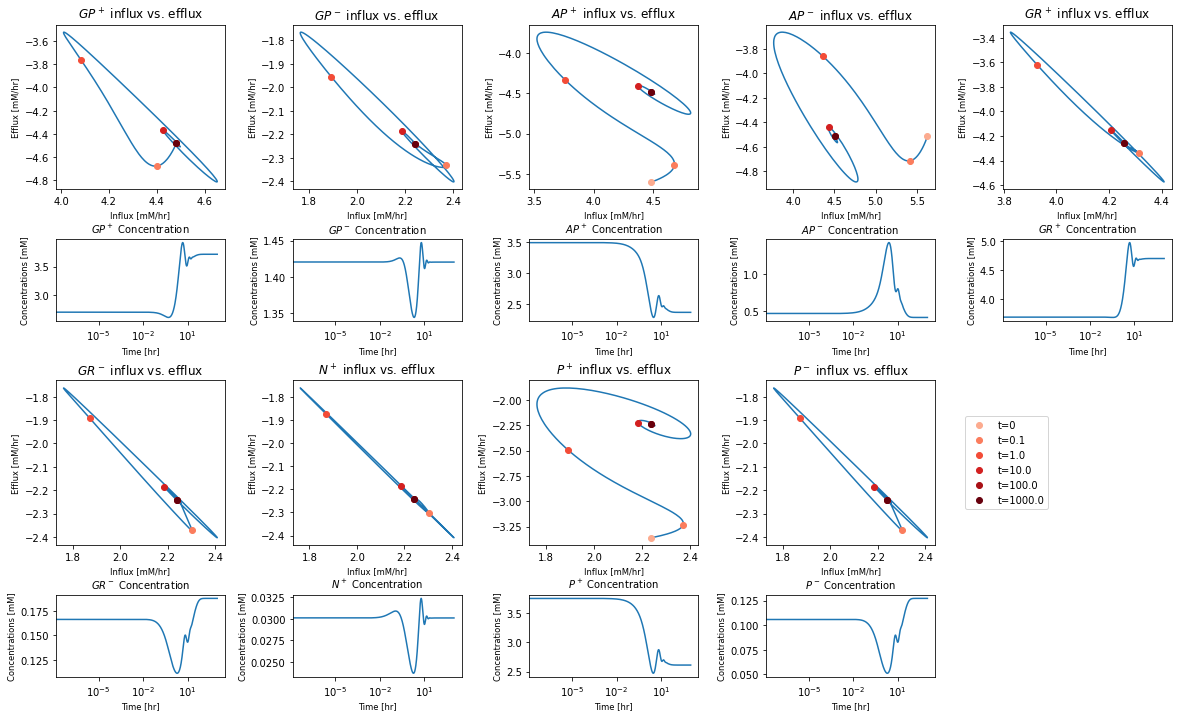

In [41]:
# Make matrix
pooling_matrix, pool_labels = make_pooling_matrix(include_all)
PS = pooling_matrix.dot(glycolysis.S)
# Make solution IDs, equations, and variables for pooled solutions
pools = {}
net_fluxes = {}
for i, pool_id in enumerate(pool_labels[:-2]):
    terms = ["*".join((str(coeff), met))
             for coeff, met in zip(pooling_matrix[i], metabolite_ids)
             if coeff != 0]
    variables = [term.split("*")[-1] for term in terms]
    pools.update({pool_id: ["+".join(terms), variables]})
    
    for flux_str, condition in zip([" influx", " efflux"], [lambda i: i > 0, lambda i: i < 0]):
        terms = ["*".join((str(coeff), rxn))
                 for coeff, rxn in zip(PS[i], reaction_ids) 
                 if condition(coeff)]
        variables = [term.split("*")[-1] for term in terms]
        net_fluxes.update({
            pool_id + flux_str: ["+".join(terms), variables]})
    
for sol_obj, equation_dict in zip([conc_sol, flux_sol],
                                  [pools, net_fluxes]):
    for sol_id, (equation, variables) in equation_dict.items():
        sol_obj.make_aggregate_solution(
            sol_id, equation=equation, variables=variables)
        
time_points = [t0, 1e-1, 1e0, 1e1, 1e2, tf]
time_point_colors = [
    mpl.colors.to_hex(c)
    for c in mpl.cm.Reds(np.linspace(0.3, 1, len(time_points)))]

# Create figure
fig_10_21 = plt.figure(figsize=(20, 12))
outer_grid = mpl.gridspec.GridSpec(nrows=2, ncols=5, wspace=.4)
for i, pool_id in enumerate(pools):
    inner_grid = mpl.gridspec.GridSpecFromSubplotSpec(
        nrows=2, ncols=1, subplot_spec=outer_grid[i], 
        height_ratios=[2, 1], hspace=.4)
    
    for j in range(2):
        ax = plt.Subplot(fig_10_21, inner_grid[j])
        if i == len(pools) - 1 and j == 0:
            legend = "right outside"
        else:
            legend = None
        if j == 0:
            plot_phase_portrait(
                flux_sol, x=pool_id + " influx", y=pool_id + " efflux", ax=ax,
                xlabel=("Influx [mM/hr]", S_FONT), 
                ylabel=("Efflux [mM/hr]", S_FONT),
                title=(pool_id + " influx vs. efflux", L_FONT),
                annotate_time_points=time_points,
                annotate_time_points_color=time_point_colors,
                annotate_time_points_legend=legend)
                
        else:
            plot_time_profile(
                conc_sol, observable=pool_id, ax=ax,
                plot_function="semilogx", 
                xlabel=("Time [hr]", S_FONT),
                ylabel=("Concentrations [mM]", S_FONT),
                title=(pool_id + " Concentration", {"size": "medium"}));
        fig_10_21.add_subplot(ax)

**Figure 10.21:** The dynamic response  of the glycolytic pools. Top, the flux phase portrait (flux in on the x-axis vs. flux out on the y-axis) is shown for each pool. Bottom, the concentration profile of the pool.

### The dual issue that underlies the formation of pools
We close this section by observing that although Eq. (10.12) does relate the fluxes to the pools, the functions for the fluxes are dependent on the concentrations. Thus, there is a dual issue here. If we are to get dynamic descriptions of the pools, we must convert the arguments in the flux vector from the concentration variables to the pools themselves. This problem is mathematically difficult to analyze and is addressed elsewhere (_Systems Biology: Volume III_). 

## Ratios: Towards Physiology  
We now take a look at the conjugate pools (i.e., the corresponding high and low states) of various metabolic properties of the glycolytic system to form property ratios. The energy charge is one such ratio and was introduced in Chapter 2. The formulation of these quantities allows a physiological interpretation of the dynamic responses. 

The notion of a charge is related to the relative size of the conjugate pools. A ratio is formed as: 

$$\begin{equation} \text{property ratio}=\frac{\text{high}}{\text{high} + \text{low}} = \frac{\text{high}}{\text{total}} \tag{10.13} \end{equation}$$

The ratios, $r_i$, are computed from the conjugates, $p_i$. We can then graph the ratios to interpret transient responses from a metabolic physiological point of view. The total pool size may change on a different time scale than the interconversion between the high and low forms. Any time scale hierarchy in such responses is of interest since most physiological responses involve multi-scale analysis. 

### Energy charges  
We can define an energy charge for glycolysis as the ratio: 

$$\begin{equation} r_1 =\frac{p_1}{p_1 + p_2} \tag{10.14} \end{equation}$$

that is an analogous quantity to the adenylate energy charge 

$$\begin{equation} r_2 =\frac{p_3}{p_3 + p_4} = \frac{2\ \text{ATP}\ +\ \text{ADP}}{2\ (\text{ATP}\ +\ \text{ADP}\ +\ \text{AMP})} \tag{10.15} \end{equation}$$

Thus, we have two ratios that describe metabolic physiology in terms of the energy charge in the glycolytic intermediates and on the adenylate phosphates. 

These charge parameters $(r_1\ \text{and}\ r_2)$ can vary between zero and unity. If the ratio is close to unity, the energy charge is high, and vice versa. The glycolytic pathway thus transfers metabolic energy equivalents from glucose to ADP. The energy charge of the glycolytic intermediates and NAD are quantities that describe how this process takes place. 

### Redox charges  
We can define the redox charge in glycolysis as 

$$\begin{equation} r_3 =\frac{p_5}{p_5 + p_6} \tag{10.16} \end{equation}$$

We note that three times the denominator in equation 0  is the total carbon inventory in glycolysis. In an analogous fashion, we can define the redox state on the NAD carrier as 

$$\begin{equation} r_4 =\frac{\text{NADH}}{\text{NADH}\ +\ \text{NAD}} = \frac{p_7}{p_{10}} \tag{10.17} \end{equation}$$

These ratios will have identical interpretations as the energy charges. Glycolysis will move redox equivalents in glucose onto NADH that then become the conduit of redox equivalent to other processes in a cell, here represented by the NADH load function. 

### The state of the phosphate groups  
We can define the state of the phosphates as 

$$\begin{equation} r_5 =\frac{p_8}{p_8 + p_9} \tag{10.18} \end{equation}$$

to get the fraction of phosphate that has been incorporated and is available for recycling or to meet the ATP demand function. 

In [42]:
# Make pool solutions
pooling_matrix, pool_labels = make_pooling_matrix(True)
pools = {}
for i, pool_id in enumerate(pool_labels[:-2]):
    terms = ["*".join((str(coeff), met))
             for coeff, met in zip(pooling_matrix[i], metabolite_ids)
             if coeff != 0]
    variables = [term.split("*")[-1] for term in terms]
    pools.update({pool_id: ["+".join(terms), variables]})

ratios = {}
keys = [
    ('$GP^+$', '$GP^-$'), ('$AP^+$', '$AP^-$'),
    ('$GR^+$', '$GR^-$'),('$N^+$', '$N^-$'),
    ('$P^+$', '$P^-$')]
ratio_names = [
    "Glycolytic Energy Charge", "Adenylate Energy Charge",
    "Glycolytic Redox Charge", "NADH Redox Charge",
    "Phosphate Recycle Ratio"]
for name, (k1, k2) in zip(ratio_names, keys):
    ratio = " / ".join(["({0})".format(pools[k1][0]), 
                        "({0} + {1})".format(pools[k1][0], pools[k2][0])])
    variables = list(set(pools[k1][1] + pools[k2][1]))
    ratios[name] = [ratio, variables]

for ratio_id, (equation, variables) in ratios.items():
    conc_sol.make_aggregate_solution(
        ratio_id, equation=equation, variables=variables)

**Table 10.14:** The numerical values of key ratios in glycolysis before and after the increased rate of ATP use.

In [43]:
table_10_14 = pd.DataFrame(
    [[ratio, conc_sol[ratio][0], conc_sol[ratio][-1]]
     for ratio in ratios], 
    index=range(1, len(ratios) + 1),
    columns=["Ratio Name", "t=0", "t=1000"])
table_10_14.index.rename("$r_i$", inplace=True)
table_10_14

,Ratio Name,t=0,t=1000
$r_i$,,,
1,Glycolytic Energy Charge,0.656,0.723
2,Adenylate Energy Charge,0.883,0.852
3,Glycolytic Redox Charge,0.957,0.962
4,NADH Redox Charge,0.338,0.338
5,Phosphate Recycle Ratio,0.973,0.954


### Operating diagrams  
The combination of the conjugate pools can be used to develop the pool diagram of Figure 10.20 further and form effectively an operating diagram for glycolysis; Figure 10.21. This diagram represents the glycolytic system as a set of interconnected charges of various properties, and is a physiological point of view. 

![Figure-10-21](../images/Ch10/Figure-10-21.png)

**Figure 10.21:** An operating diagram for the glycolytic systems.

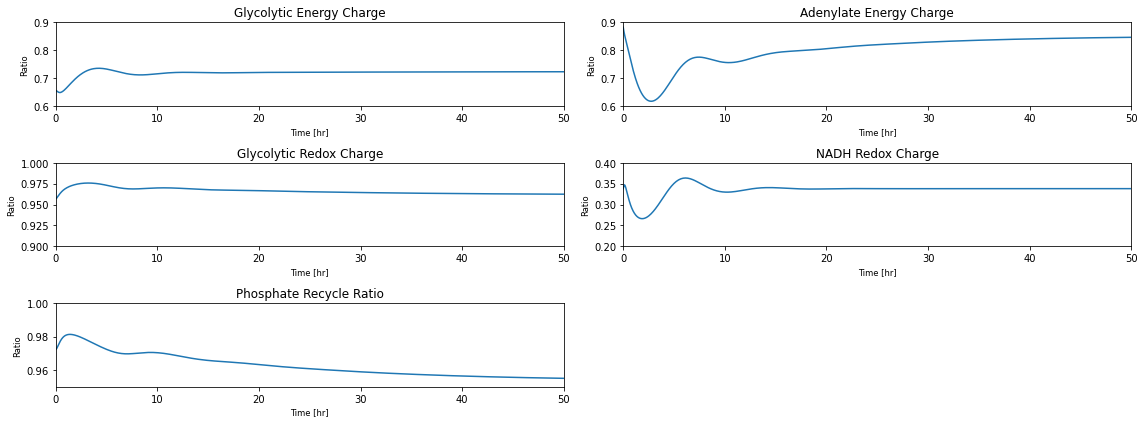

In [44]:
fig_10_22, axes = plt.subplots(nrows=3, ncols=2, figsize=(16, 6))
axes = axes.flatten()
axes, ax6 = (axes[:5], axes[5:])
fig_10_22.delaxes(ax6[0])

ylims = [(0.6, 0.9), (0.6, 0.9), (0.9, 1), (0.2, 0.4), (0.95, 1)]
for i, (ax, ratio) in enumerate(zip(axes, list(ratios))):
    plot_time_profile(
        conc_sol, observable=ratio, ax=axes[i],
        xlim=(t0, 50), ylim=ylims[i],
        xlabel=("Time [hr]", S_FONT), 
        ylabel=("Ratio", S_FONT), title=(ratio, L_FONT))
fig_10_22.tight_layout()

**Figure 10.22:** The dynamic response of the glycolytic property ratios.

### Dynamic responses of the ratios  

The ratios can easily be computed from the time profiles of the pools. The response of the ratios is shown on the glycolytic operating diagram (Figure 10.21) in Figure 10.22. We now see the simplicity in the dynamic reaction of the glycolytic system to the increased rate of ATP usage. 

* The energy charge experiences a significant drop initially, but then recovers over a long time period, due to the reduction in the total adenosine phosphate ATP + ADP + AMP pool.


* The phosphate charge has a similar but much less pronounced adjustment. 


* The energy charge of glycolysis increases. 


* There are minor ripple effects through the redox pools. 

Note that these responses are built into the stoichiometry and the numerical values of the rate constants. No regulatory mechanisms are required to obtain these systemic responses. 

## Assumptions  
The glycolytic MASS model has several assumptions built into it. The user of models and dynamic simulators needs to be aware of the assumptions that underlie a model, and these assumptions need to be taken into account when interpreting the results from the simulation. The effects of assumptions can be examined by simulations that test these assumptions. 

### The time invariant pools  
The total amount of the NADH redox carrier and the total amount of phosphate are constants in the glycolytic system studied. The operating diagram shows the consequences of the time invariant pools. The total NADH is constant as it does not leave or enter the system. The total phosphate pool is a constant. The phosphate group is found in three different forms. We note that the incorporation of $\text{P}_i$ and its formation from the ATP load reaction are from the same source. We study the consequences of these conservations through the homework sets given below. 

### Constant inputs and environment  
The model studied assumes that the glucose and AMP inputs are constants and that the plasma concentrations of PYR and LAC are constants, as well as the external pH. 

Normally, inflows of nutrients into a cell are regulated. For instance, if the energy requirement of a human cell goes up, then the glucose input would be expected to be regulated to increase. The glucose transporters into human cells are carefully regulated (Leney 2009, Petersen 2002, Watson 2006). 

Similarly, the AMP input is influenced by other cellular processes. We will look at the effect of the nucleotide salvage pathways in Chapter 12. Through the simulations performed in this chapter, we have discovered that this input rate is important for the long-term function of the system and for the determination of its energy state. The salvage pathways have an important physiological role, and many serious inborn errors of metabolism are associated with genetic defects in this nucleotide salvage process (Dudzinska 2006, McMullin 1999). 

The composition of the plasma is variable. For instance, the normal range of pyruvate concentration in plasma is 0.06 to 0.11 mM, and that for lactate is 0.4 to 1.8 mM. Here, we did fix these conditions to one condition. One can simulate the response to changes in plasma concentrations. 

### Constant volume and charge neutrality  
As discussed in Chapter 1, there are several fundamental assumptions that underlie the formulation of the dynamic mass balances. These include charge neutrality of the compounds and electroneutrality of the interior and exterior of the cell. The simulator studied here assumed neutral molecules and had no osmotic effects on the volume of the system. 

### Regulation  
There were no regulatory mechanisms incorporated into this model. In Chapters 14 we will discuss how regulated enzymes are described in MASS models. 

## Summary 
* The glycolytic pathway is converted in to a system with systems boundary, and inputs and outputs

* The topological characteristics of the stoichiometric matrix are elucidated in terms of three key pathways that span the null space of $\textbf{S}$ and two pools that span the left null space of  $\textbf{S}$.

* From three flux measurements we can determine the weightings on the three pathways and specify the steady state flux map

* From measured concentrations and the computed flux map, we can calculate the PERCs and complete the steady state description of the glycolytic system.

* Initial draft MASS models can be obtained from using measured concentration values, elementary reactions, and associated mass action kinetics. These first draft kinetic models can be used as a scaffold to build more complicated models that include regulatory effects and interactions with other pathways. 

* Dynamic simulations can be performed for perturbations in environmental parameters, and the responses can be examined in terms of the concentrations and the fluxes. Tiled phase portraits are useful to get an overall view of the dynamic response. 

* A metabolic map can be analyzed for its stoichiometric texture to assess consequences of cofactor coupling. Such reduction of the biochemical network helps define pools that are physiologically meaningful from a metabolic perspective and are context dependent. 

* Some of the responses, namely damped oscillatory behavior, are built into the topological features of a network and require no regulatory action. 

* The raw output of the simulation can be post-processed with a pooling matrix that allows the pools and their ratios to be graphed to obtain a deeper interpretation of dynamic responses. 

* MASS models, post processing, and analysis of responses allows study at three levels: 1) biochemistry, 2) systems biology, and 3) physiology. 

## Applications
### Examining the constraints a Constant Total Phosphate Pool
The total phosphate pool can be a constraint on the capabilities of the glycolytic model. This constraint prevents the model to respond to some environmental stimuli or boundary fluxes.  Red blood cells can import/export phosphate from/to the surrounding plasma.  Thus if a phosphate transporter is added to the model this unrealistic constraint is removed.

#### Simulating increased glucose uptake rate  
Here we simulate the response of the glycolytic system without the phosphate transporter to a 20% increase in the glucose uptake rate. Observe what happens to the fraction of phosphate in the recycle pool.  We then add a phosphate transporter to alleviate this constraint.

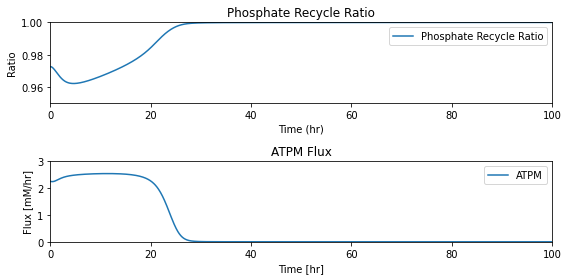

In [45]:
t0, tf = (0, 100)
# Simulate and make ratio
ratio_id = 'Phosphate Recycle Ratio'
perturbation_dict = {"kf_SK_glc__D_c": "kf_SK_glc__D_c*1.2"}

phosphate_ratio = {ratio_id: ratios[ratio_id]}
terms, variables = [], []
for k in ['$P^+$', '$P^-$']:
    terms.append(pools[k][0])
    variables.append(pools[k][1])

phosphate_ratio.update({
    "P_tot": ["+".join(terms), list(set(variables[0] + variables[1]))]})

conc_sol, flux_sol = sim_glycolysis.simulate(
    glycolysis, time=(t0, tf),
    perturbations=perturbation_dict)

for ratio, (equation, variables) in phosphate_ratio.items():
    conc_sol.make_aggregate_solution(
        ratio, equation=equation, variables=variables)
    
fig_10_23, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 4));
(ax1, ax2) = axes.flatten()

plot_time_profile(
    conc_sol, observable='Phosphate Recycle Ratio', ax=ax1,
    legend="upper right", 
    xlabel="Time (hr)", ylabel="Ratio", 
    xlim=(t0, tf), ylim=(.95, 1),
    title=(ratio_id, L_FONT));

plot_time_profile(
    flux_sol, observable="ATPM", ax=ax2, legend="upper right",
    xlabel="Time [hr]", ylabel="Flux [mM/hr]", 
    xlim=(t0, tf), ylim=(-.001, 3), title=("ATPM Flux", L_FONT));
fig_10_23.tight_layout()

**Figure 10.23:** (a) Computation of the phosphate recycle ratio for changes in the glucose uptake rate. Note how high this ratio is. (b) Computation of the ATP usage rate with changes in the glucose uptake rate.

Once the glucose increase hits a certain threshold, the ATP load flux cannot balance, and the system breaks down.  At 20% increase in the glucose uptake rate, this ratio hits unity.  All the phosphate is found in the recycle pool making it impossible to deliver any energy phosphate bonds.  We can examine the ATP usage rate under the same conditions.

#### Adding phosphate exchange reaction with surrounding plasma  
Now we add a reaction $v_P = k_P^{\rightarrow}(P_i − P_{i,plasma})$ where $P_{i,plasma} = 2.5$ and $k_P^{\rightarrow}$ is 0.23/hr (Prankerd, T., & Altman, K., 1954) and repeat the simulations from above.

In [46]:
# Duplicate the model
glycolysis_w_phos = glycolysis.copy()
glycolysis_w_phos.id += "_w_Phosphate"
# Add phosphate exchange reaction with external phosphate concentration set to 2.5 mM
SK_pi_c = glycolysis_w_phos.add_boundary(
    metabolite=glycolysis_w_phos.metabolites.get_by_id("pi_c"), 
    boundary_type="sink",  boundary_condition=2.5)

# Set forward rate constant
SK_pi_c.kf = 0.23
SK_pi_c.Keq = 1

#### Changes in topological properties 
The dimensions of $\textbf{S}$ are now 20x22 and the rank is 19.  Thus, the left space in one dimensional but the null space is still 3-dimensional. 

Lets examine the left null space of the stoichiometric model.  First we see that its dimension has dropped to one, and the only left null space vector is the NAD+NADH pool (Table 10.15).  The total phosphate conservation pool has disappeared since we now have a transporter that dynamically adjusts the total phosphate inventory.

**Table 10.15:** The left null space pool of the updated glycolytic system. The total phosphate pool is not found.

In [47]:
lns = left_nullspace(glycolysis_w_phos.S, rtol=1e-10)
# Iterate through left nullspace, 
# dividing by the smallest value in each row. 
for i, row in enumerate(lns):
    minval = np.min(abs(row[np.nonzero(row)]))
    new_row = np.array(row/minval)
    # Round to ensure the left nullspace is composed of only integers
    lns[i] = np.array([round(value) for value in new_row])
    
# Ensure positive stoichiometric coefficients if all are negative
for i, space in enumerate(lns):
    lns[i] = np.negative(space) if all([num <= 0 for num in space]) else space

# Create labels for the time invariants
table_10_15 = pd.DataFrame(lns, index=["$N_{\mathrm{tot}}$"],
                           columns=metabolite_ids)
table_10_15

,glc__D_c,g6p_c,f6p_c,fdp_c,dhap_c,g3p_c,_13dpg_c,_3pg_c,_2pg_c,pep_c,pyr_c,lac__L_c,nad_c,nadh_c,amp_c,adp_c,atp_c,pi_c,h_c,h2o_c
$N_{\mathrm{tot}}$,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,1.000,1.000,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000


#### Dynamic simulation 
We can now re-simulate the dynamic response of the system to changed glucose uptake rate and we see that the system can now rebalance the phosphate recycle ratio.  The model is now more realistic. It re-adjusts the size of the phosphate pool.  We can examine how the boundary fluxes change. At 20% increase in the glucose uptake rate the system does reach a new steady state.

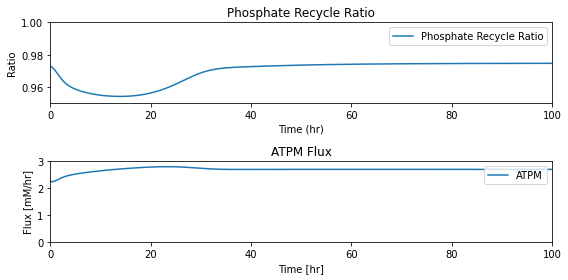

In [48]:
sim_glycolysis_w_phos = Simulation(glycolysis_w_phos)
conc_sol, flux_sol = sim_glycolysis_w_phos.simulate(
    glycolysis_w_phos, time=(t0, tf), 
    perturbations=perturbation_dict)

for ratio, (equation, variables) in phosphate_ratio.items():
    conc_sol.make_aggregate_solution(
        ratio, equation=equation, variables=variables)

fig_10_24, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 4), 
                               );
(ax1, ax2) = axes.flatten()

plot_time_profile(
    conc_sol, observable=ratio_id, ax=ax1, legend="upper right",
    xlabel="Time (hr)", ylabel="Ratio", 
    xlim=(t0, tf), ylim=(.95, 1), title=(ratio_id, L_FONT));

plot_time_profile(
    flux_sol, observable="ATPM", ax=ax2, legend="upper right",
    xlabel="Time [hr]", ylabel="Flux [mM/hr]", 
    xlim=(t0, tf), ylim=(-.001, 3), title=("ATPM Flux", L_FONT));
fig_10_24.tight_layout()

**Figure 10.24:** (a) Computation of the phosphate recycle ratio for changes in the glucose uptake rate in the updated model. (b) Computation of the ATP usage rate with changes in the glucose uptake rate in the updated model.

We can now examine other properties of the response of the updated glycolytic system.  The ATP demand can be met at a 20% increase in glucose uptake rate.  The size of the total phosphate pool is increased over time.  The phase portrait of the total phosphate pool and the phosphate transporter shows that phosphate is taken up (i.e. negative flux on the inorganic phosphate exchange rate, $v_P$ and the total phosphate concentration builds up.  There is an overshoot and the phosphate is secreted and the pool size drops and settles down in a new steady state. If you try the simulation at 5% increase in the glucose uptake rate, you will see no such overshoot. The second flux phase portrait shows that AMP leaves the system during this transition.

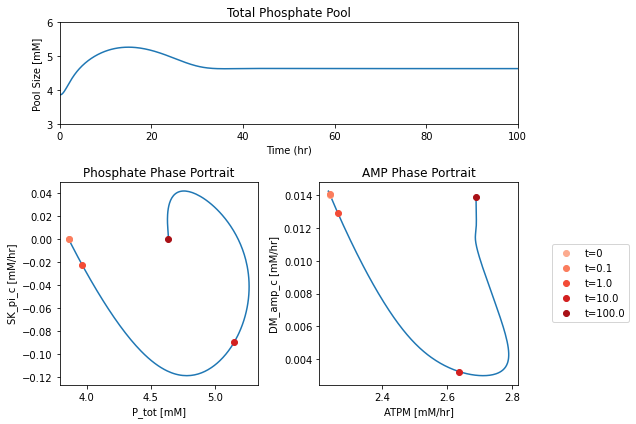

In [49]:
fig_10_25 = plt.figure(figsize=(9, 6))
gs = fig_10_25.add_gridspec(nrows=2, ncols=2, width_ratios=[1, 1], 
                            height_ratios=[.5, 1])

ax1 = fig_10_25.add_subplot(gs[0, :])
ax2 = fig_10_25.add_subplot(gs[1, 0])
ax3 = fig_10_25.add_subplot(gs[1, 1])

time_points = time_points[:-1]
time_point_colors = time_point_colors[:-1]
conc_sol.update({SK_pi_c.id: flux_sol[SK_pi_c.id]})

plot_time_profile(
    conc_sol, observable="P_tot", ax=ax1,
    xlim=(t0, tf), ylim =(3, 6),
    xlabel="Time (hr)", ylabel="Pool Size [mM]",
    title=("Total Phosphate Pool", L_FONT))

plot_phase_portrait(
    conc_sol, x="P_tot", y=SK_pi_c.id, ax=ax2,
    xlabel="P_tot [mM]", ylabel="SK_pi_c [mM/hr]", 
    title=("Phosphate Phase Portrait", L_FONT),
    annotate_time_points=time_points,
    annotate_time_points_color=time_point_colors)

plot_phase_portrait(
    flux_sol, x="ATPM", y="DM_amp_c", ax=ax3,
    xlabel="ATPM [mM/hr]", ylabel="DM_amp_c [mM/hr]", 
    title=("AMP Phase Portrait", L_FONT),
    annotate_time_points=time_points,
    annotate_time_points_color=time_point_colors,
    annotate_time_points_legend="right outside")
fig_10_25.tight_layout()

**Figure 10.25:** Plotting response characteristics of the updated glycolytic system.

$\tiny{\text{© B. Ø. Palsson 2011;}\ \text{This publication is in copyright.}\\ \text{Subject to statutory exception and to the provisions of relevant collective licensing agreements,}\\ \text{no reproduction of any part may take place without the written permission of Cambridge University Press.}}$